Arjun Joshi
11/10/2024
BrainStation
Deliverable 5: NLP, Advanced Stas & Modelling


##### Assignment Instructions

                **Exploratory Data Analysis**
                            <br>
 For this analysis, you are provided with a large data set consisting of hotel reviews (text fields for positive and negative comments) and details about the stay (hotel location, time & length of stay, etc). Your target column of interest is Reviewer_Score that encodes positive sentiment as 1 and negative as 0.

First, let's load the data and understand what we are working with.

Perform EDA on the data and mention 3-4 observations from which you can draw actionable insights. In your EDA, you may consider creating a data dictionary, basic statistical analysis, data visualizations, data cleaning and preprocessing to prepare the data for modeling.

                        Preprocessing
                            <br>
Next, the text data needs to be processed for modelling.

Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following:
What tokenizer and text cleaning steps do you include?
Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.
This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).
                        
                          Modelling
                            <br>
As the data is now ready for modelling, we will be creating two separate models with optimization and evaluation of each.

Fit a logistic regression model on the data and analyze the test and train accuracy. Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1). Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0). What actionable insights can you draw from these?
        
                        Pipeline & PCA
        
Using a pipeline, combine PCA with a decision tree classifier.
Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.
You can use 20 principle components.
The best parameters should be found using 5-fold cross validation.
Contrast the best results here with the logistic regression model and provide any insights that you may draw from the results.

                        Confusion Matrix
*[jump to code cell 2](#cell2)

For your best performing model, conduct a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.
Requirements
Please submit your Jupyter notebook which should include commented code and extensive markdown cells explaining your process and insights. Make sure to add a table of contents, introduction, proper section headers and a conclusion section. Your communication in the markdown cells and the code cell outputs should allow anyone to understand your process and findings without the need to read the code.

# Table of Contents

[Part 1: Data Preprocessing, EDA](Part111)

[Part 1: Data Preprocessing, EDA](Part1)

[Part 2: Text Preprocessing](Part2)

[Part 3:TT_Split Tokenize, LogReg Fitting](Part3)

[Part 4: Pipeline & PCA](Part4)

[Part 5: Confusion Matrix](Part2)

[Index:Data Dictionary](Index)

## Part 0: Load, Format, Custom Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from scipy import stats

filterwarnings(action='ignore')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer


### DF check

In [2]:
hotel=pd.read_csv('data/Hotel_Reviews.csv')

In [3]:
# overview of objects

# 2 Objects are positive and negative review content 
# Target Variables
#### 
hotel.columns

Index(['Unnamed: 0', 'Additional_Number_of_Scoring', 'Average_Score',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'Days_Since_Review', 'Latitude', 'Longitude', 'Day', 'Month', 'Year',
       'Reviewer_Nationality_Australia', 'Reviewer_Nationality_Ireland',
       'Reviewer_Nationality_UAE', 'Reviewer_Nationality_UK',
       'Reviewer_Nationality_USA', 'Reviewer_Nationality_Other',
       'Hotel_Address_Amsterdam', 'Hotel_Address_Barcelona',
       'Hotel_Address_London', 'Hotel_Address_Milan', 'Hotel_Address_Paris',
       'Hotel_Address_Vienna', 'Leisure_Trip', 'Nights_Stayed'],
      dtype='object')

In [4]:
hotel.shape

(515738, 30)

In [5]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Unnamed: 0                                  515738 non-null  int64  
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Average_Score                               515738 non-null  float64
 3   Negative_Review                             515738 non-null  object 
 4   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 5   Total_Number_of_Reviews                     515738 non-null  int64  
 6   Positive_Review                             515738 non-null  object 
 7   Review_Total_Positive_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews_Reviewer_Has_Given  515738 non-null  int64  
 9   Reviewer_Score                              515738 non-null  int64  
 

In [6]:
#hotel.rename(columns={'Unnamed: 0' : 'old_index'}, inplace=True)

In [7]:
# 'Old-index' contains no new information, as expected. Dropping column
#
for rows in hotel['Unnamed: 0']:
    if hotel.index[rows] == hotel['Unnamed: 0'][rows]:
        continue
    else:
        print(rows)
print('done')

# drop columns
#
hotel.drop(columns=['Unnamed: 0'], inplace=True)

done


In [8]:
# Redo columns of df to make it more readable

hotel=hotel[['Reviewer_Score',
 'Nights_Stayed',
 'Positive_Review',
 'Negative_Review',
 'Additional_Number_of_Scoring',
 'Average_Score',
 'Leisure_Trip', 
 'Days_Since_Review',
 'Total_Number_of_Reviews', 
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'Review_Total_Negative_Word_Counts', 
 'Review_Total_Positive_Word_Counts',
 'Latitude',
 'Longitude',
 'Day',
 'Month',
 'Year',
 'Reviewer_Nationality_Australia',
 'Reviewer_Nationality_Ireland',
 'Reviewer_Nationality_UAE',
 'Reviewer_Nationality_UK',
 'Reviewer_Nationality_USA',
 'Reviewer_Nationality_Other',
 'Hotel_Address_Amsterdam',
 'Hotel_Address_Barcelona',
 'Hotel_Address_London', 
 'Hotel_Address_Milan', 
 'Hotel_Address_Paris',
 'Hotel_Address_Vienna']]


In [9]:
# No null values
hotel.isna().sum().sum()

0

In [10]:
# After removing old index, we can actually take a look a possible duplicates. The old index was a hindrance and it was shown
# in the earlier loop that it matches the index.

hotel.duplicated().value_counts()

False    515199
True        539
Name: count, dtype: int64

In [11]:
# Take a look at a duplicate line
hotel.loc[hotel.Year.eq(2015) & hotel.Day.eq(4) & hotel.Month.eq(8) & hotel.Reviewer_Nationality_UK.eq(1) & hotel.Total_Number_of_Reviews.eq(2515)]	

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
180112,1,1,Very convenient for Gare de Montparnasse,Need better directions from Metro,228,7.9,1,730,2515,9,...,0,1,0,0,0,0,0,0,1,0
180458,1,1,Very convenient for Gare de Montparnasse,Need better directions from Metro,228,7.9,1,730,2515,9,...,0,1,0,0,0,0,0,0,1,0


In [12]:
# Drop the duplicates, keep one copy. Index irrelevant presently, dropping first.

print(hotel.drop_duplicates(keep='first').shape)
hotel.drop_duplicates(keep='first',inplace=True)
print(hotel.shape)

(515199, 29)
(515199, 29)


In [13]:
# Checking duplicates after drop again

hotel.duplicated().value_counts()

False    515199
Name: count, dtype: int64

In [14]:
hotel.head(2)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0
1,0,4,No real complaints the hotel was great great ...,No Negative,194,7.7,1,0,1403,7,...,0,0,0,0,1,0,0,0,0,0


In [15]:
## Checking for special characters
print(hotel.Positive_Review.str.isalnum().value_counts())
print(hotel.Negative_Review.str.isalnum().value_counts())

Positive_Review
False    515186
True         13
Name: count, dtype: int64
Negative_Review
False    515193
True          6
Name: count, dtype: int64


In [16]:
hotel2=hotel.copy()

In [17]:
# No Negative value = null

hotel2[hotel2.Negative_Review=='No Negative'].Negative_Review=''

In [18]:
# Taking a look at special characters in review columns - may have to revisit this after talking to faculty.

#hotel[hotel.Negative_Review.str.isalnum()==True]

In [19]:
hotel.Positive_Review.str.isalnum().value_counts()

Positive_Review
False    515186
True         13
Name: count, dtype: int64

#### Data Dictionary

In [20]:
# Create a sample DataFrame
data = {
    'type': []
}
df = pd.DataFrame(data)
data_dictionary = pd.DataFrame(index=df.columns, columns=hotel.columns)
# Create a data dictionary


In [21]:
data_dictionary

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
hotel.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0


In [23]:
data_dictionary

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
is_na=[]
dtype=[]
duplicated=[]

# Establishing columns as needed
for col in hotel.columns:
    data_dictionary[col].type=hotel[col].dtype
    print(hotel[col].dtype)

int64
int64
object
object
int64
float64
int64
int64
int64
int64
int64
int64
float64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


In [25]:
hotel['Average_Score'].isna().value_counts()

Average_Score
False    515199
Name: count, dtype: int64

In [26]:
data_dictionary=data_dictionary.T

In [27]:
data_dictionary

,type
Reviewer_Score,int64
Nights_Stayed,int64
Positive_Review,object
Negative_Review,object
Additional_Number_of_Scoring,int64
Average_Score,float64
Leisure_Trip,int64
Days_Since_Review,int64
Total_Number_of_Reviews,int64
Total_Number_of_Reviews_Reviewer_Has_Given,int64


In [28]:
data_dictionary

,type
Reviewer_Score,int64
Nights_Stayed,int64
Positive_Review,object
Negative_Review,object
Additional_Number_of_Scoring,int64
Average_Score,float64
Leisure_Trip,int64
Days_Since_Review,int64
Total_Number_of_Reviews,int64
Total_Number_of_Reviews_Reviewer_Has_Given,int64


In [29]:
# data_dictionary=data_dictionary.T

In [30]:
hotel.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0


In [31]:
print('nullls: ',hotel.isna().sum().sum())
print('\nDuplicated: \n',hotel.duplicated().value_counts())

nullls:  0

Duplicated: 
 False    515199
Name: count, dtype: int64


## Question 1: EDA 

<a class="anchor" name="Part1"></a>

In [32]:
hotel.head(3)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0
1,0,4,No real complaints the hotel was great great ...,No Negative,194,7.7,1,0,1403,7,...,0,0,0,0,1,0,0,0,0,0
2,0,3,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,194,7.7,1,3,1403,9,...,0,0,0,0,1,0,0,0,0,0


In [33]:
# Convert dates into continuous date column for plotting purposes

hotel['Review_Date'] = pd.to_datetime(hotel[['Year', 'Month', 'Day']])
hotel.Review_Date

0        2017-08-03
1        2017-08-03
2        2017-07-31
3        2017-07-31
4        2017-07-24
            ...    
515733   2015-08-30
515734   2015-08-22
515735   2015-08-19
515736   2015-08-17
515737   2015-08-09
Name: Review_Date, Length: 515199, dtype: datetime64[ns]

<Axes: xlabel='Review_Date'>

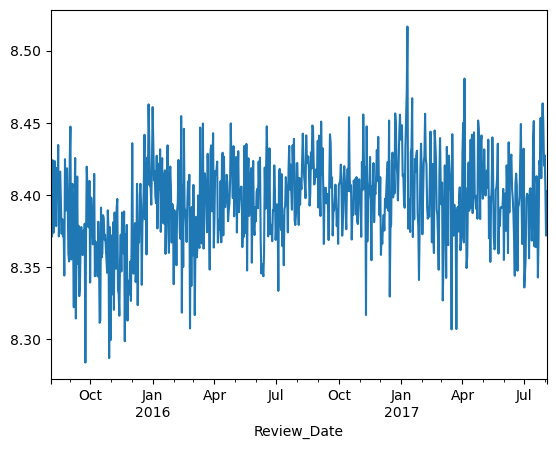

In [34]:
averages=pd.DataFrame
averages=hotel.groupby('Review_Date').Average_Score.mean()

averages.shape
hotel.groupby('Review_Date')['Average_Score'].mean().plot()

<Axes: xlabel='Review_Date', ylabel='Average_Score'>

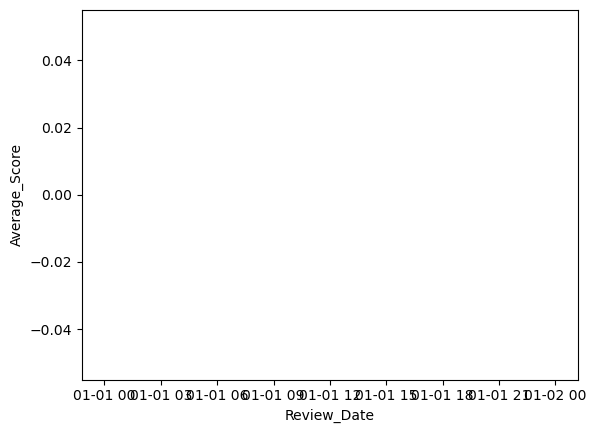

In [35]:
sns.lineplot(x=hotel.Review_Date,y=hotel.groupby('Review_Date')['Average_Score'].mean())

In [36]:

#sns.lineplot(x=hotel['Review_Date'], y=hotel())

In [37]:
AverageReviews=hotel.groupby('Review_Date').Average_Score.rolling(window=5).mean().to_frame().reset_index()

In [38]:
AverageReviews['Average_Score_std']=hotel.groupby('Review_Date').Average_Score.mean()

In [39]:
AverageReviews['monthYear']=AverageReviews.Review_Date.dt.month.astype('str')+'-'+AverageReviews.Review_Date.dt.year.astype('str')

### EDA

#### Visualizations

In [40]:
hotel.shape

(515199, 30)

In [41]:
len(pd.concat([hotel.Additional_Number_of_Scoring,hotel.Total_Number_of_Reviews]).unique())

1360

In [42]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515199 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Reviewer_Score                              515199 non-null  int64         
 1   Nights_Stayed                               515199 non-null  int64         
 2   Positive_Review                             515199 non-null  object        
 3   Negative_Review                             515199 non-null  object        
 4   Additional_Number_of_Scoring                515199 non-null  int64         
 5   Average_Score                               515199 non-null  float64       
 6   Leisure_Trip                                515199 non-null  int64         
 7   Days_Since_Review                           515199 non-null  int64         
 8   Total_Number_of_Reviews                     515199 non-null  int64         
 9 

In [43]:
hotel.columns[0:17]

Index(['Reviewer_Score', 'Nights_Stayed', 'Positive_Review', 'Negative_Review',
       'Additional_Number_of_Scoring', 'Average_Score', 'Leisure_Trip',
       'Days_Since_Review', 'Total_Number_of_Reviews',
       'Total_Number_of_Reviews_Reviewer_Has_Given',
       'Review_Total_Negative_Word_Counts',
       'Review_Total_Positive_Word_Counts', 'Latitude', 'Longitude', 'Day',
       'Month', 'Year'],
      dtype='object')

In [44]:
#hotel no location dummies
hotel_nd=hotel[hotel.columns[0:17]]

In [45]:
# sns.pairplot(hotel_nd,hue='Reviewer_Score')

With this wildly unnecessary pair-plot, I can get a sense of where some obvious relationships can be found.
Some items of interest:
- There seems to be a differential between control groups(number of review a reviewer has given ~ Average Score)
- 


In [46]:
#need another table to drop reviews
hotel_nd_nreviews=hotel_nd

In [47]:
hotel_nd_nreviews.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Latitude,Longitude,Day,Month,Year
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,397,11,52.360576,4.915968,3,8,2017


In [48]:
hotel_nd_nreviews=hotel_nd.copy()

In [49]:
hotel_nd_nreviews.drop(columns=(['Positive_Review','Negative_Review']),inplace=True)

In [50]:
hotel_nd_nreviews.head(1)

,Reviewer_Score,Nights_Stayed,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Latitude,Longitude,Day,Month,Year
0,0,6,194,7.7,1,0,1403,7,397,11,52.360576,4.915968,3,8,2017


<function matplotlib.pyplot.show(close=None, block=None)>

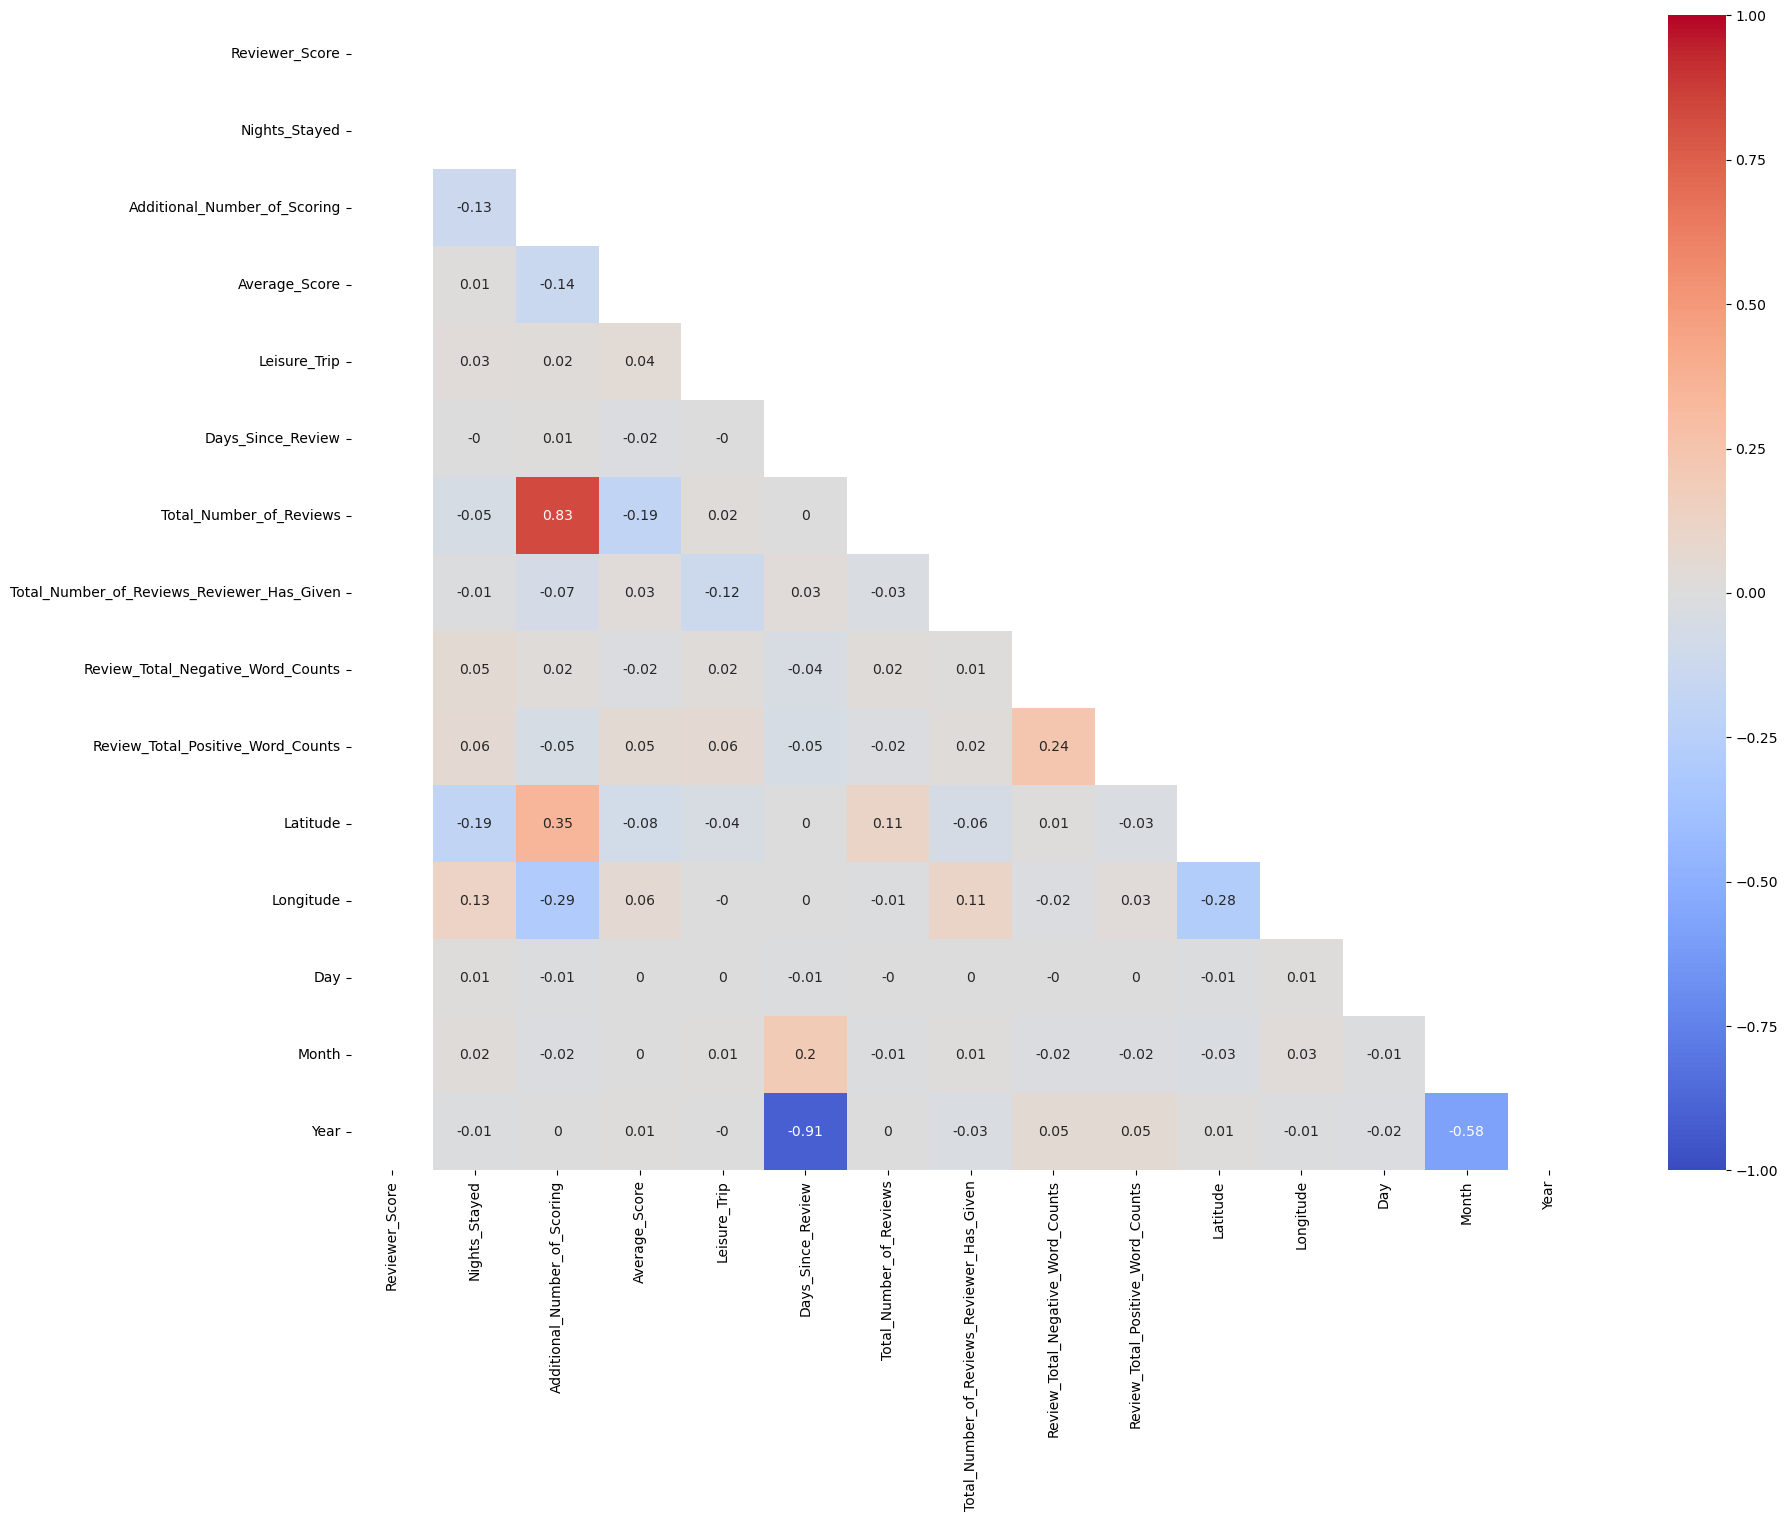

In [51]:
# Correlations for independent variables
indcorr=hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==1].corr()
#Heatmap
mask=np.triu(indcorr)
plt.figure(figsize=(20,15))
sns.heatmap(indcorr.round(2), vmax=1,vmin=-1,center=0,cmap='coolwarm',mask=mask, annot=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

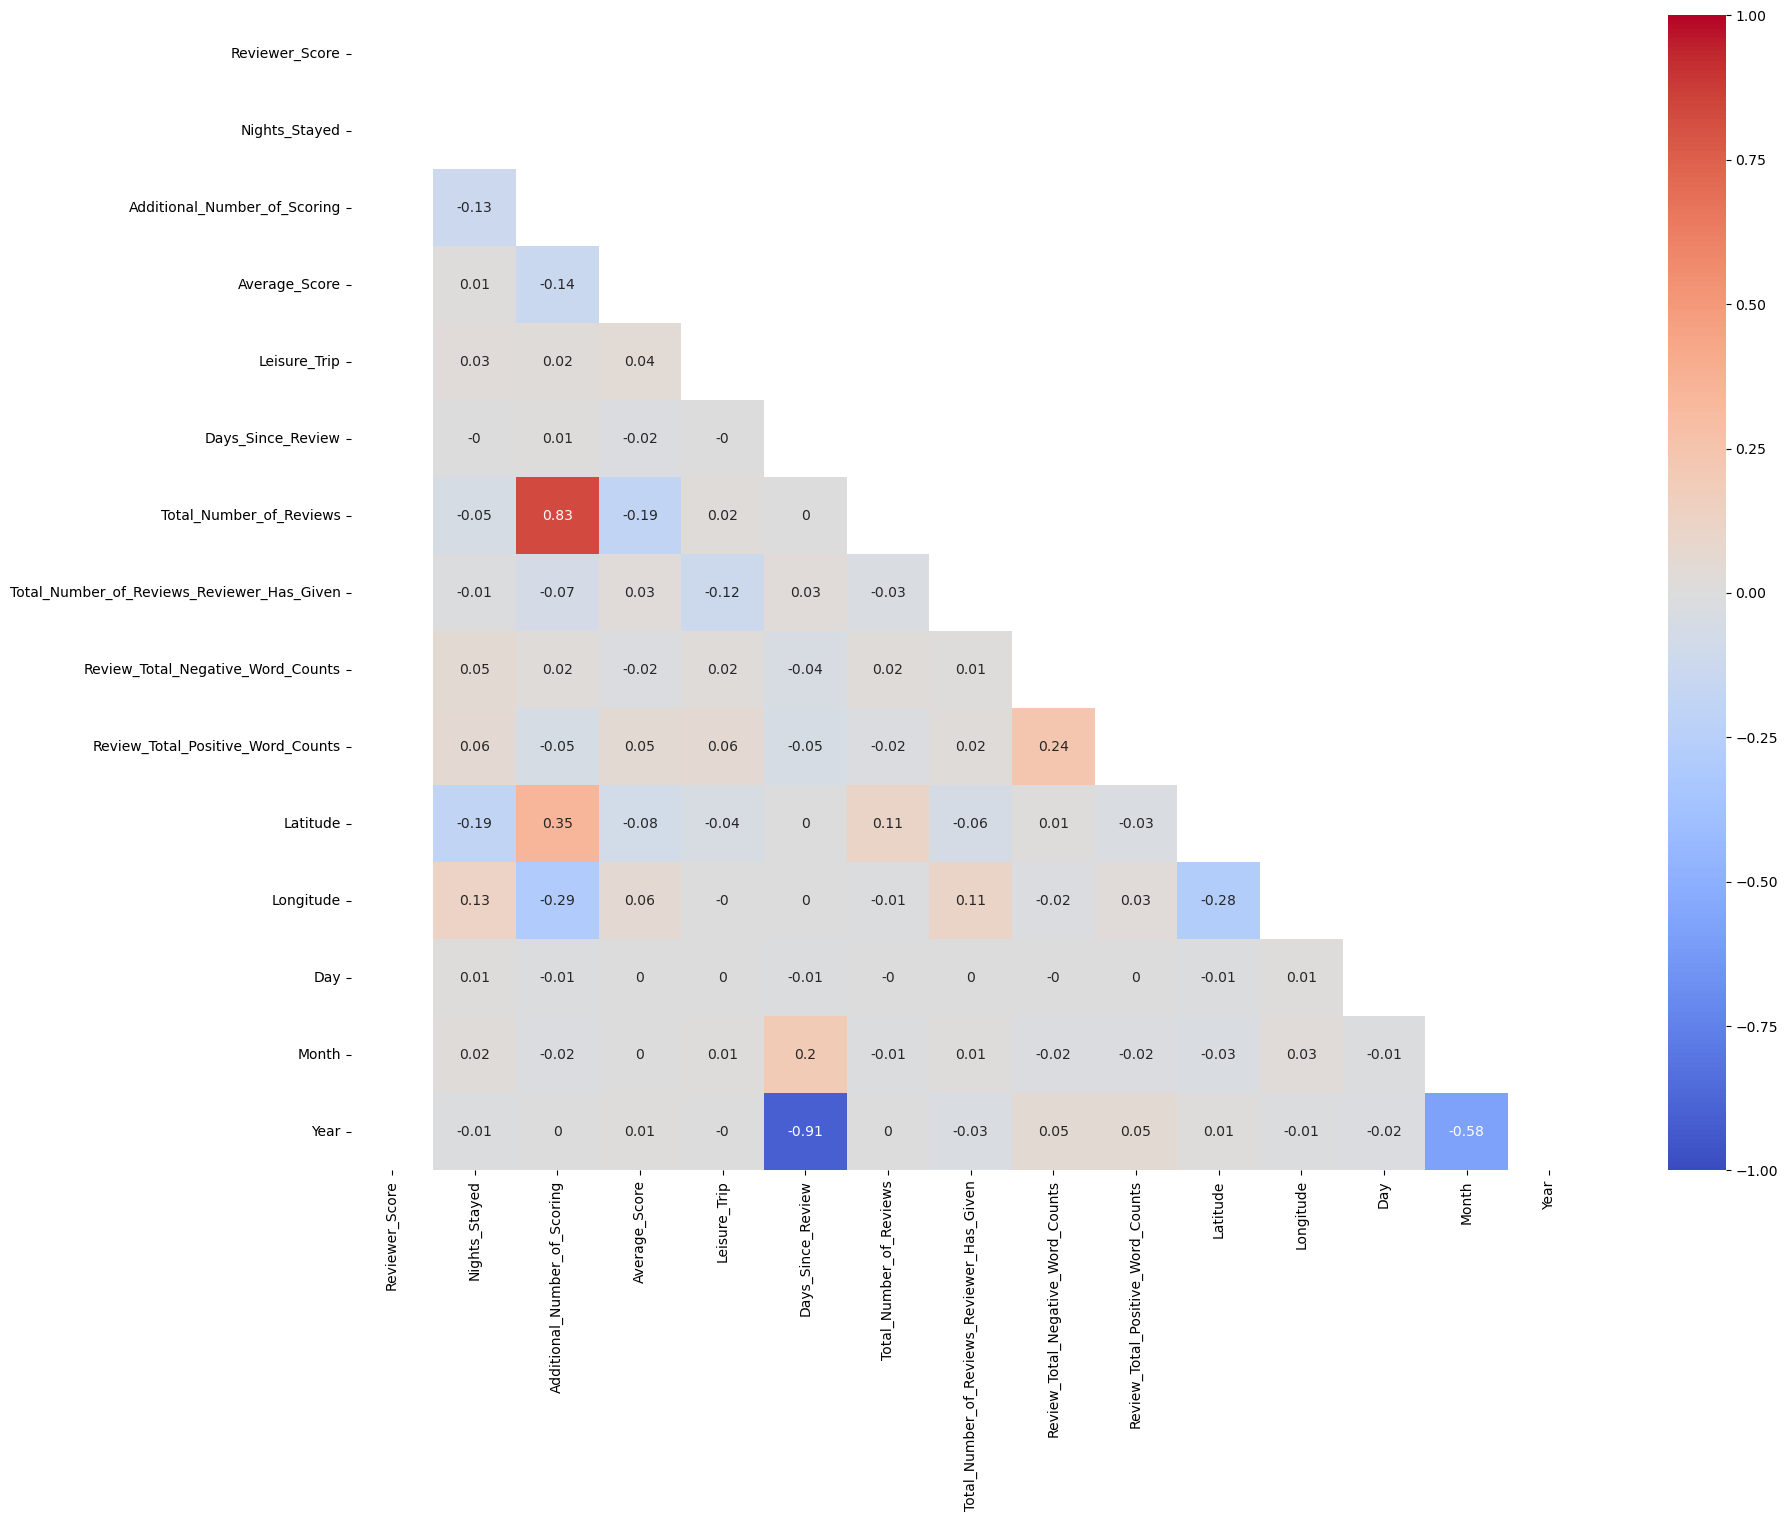

In [52]:
# Correlations for independent variables
indcorr=hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==1].corr()
#Heatmap
mask=np.triu(indcorr)
plt.figure(figsize=(20,15))
sns.heatmap(indcorr.round(2), vmax=1,vmin=-1,center=0,cmap='coolwarm',mask=mask, annot=True)
plt.show

In [53]:
inverse_hotel_nd_nreviews=hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==0]
#inverse_hotel_nd_nreviews.Reviewer_Score=1

In [54]:
hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==1].count()

Reviewer_Score                                293715
Nights_Stayed                                 293715
Additional_Number_of_Scoring                  293715
Average_Score                                 293715
Leisure_Trip                                  293715
Days_Since_Review                             293715
Total_Number_of_Reviews                       293715
Total_Number_of_Reviews_Reviewer_Has_Given    293715
Review_Total_Negative_Word_Counts             293715
Review_Total_Positive_Word_Counts             293715
Latitude                                      293715
Longitude                                     293715
Day                                           293715
Month                                         293715
Year                                          293715
dtype: int64

In [55]:
inverse_hotel_nd_nreviews.head(3)

,Reviewer_Score,Nights_Stayed,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Latitude,Longitude,Day,Month,Year
0,0,6,194,7.7,1,0,1403,7,397,11,52.360576,4.915968,3,8,2017
1,0,4,194,7.7,1,0,1403,7,0,105,52.360576,4.915968,3,8,2017
2,0,3,194,7.7,1,3,1403,9,42,21,52.360576,4.915968,31,7,2017


<function matplotlib.pyplot.show(close=None, block=None)>

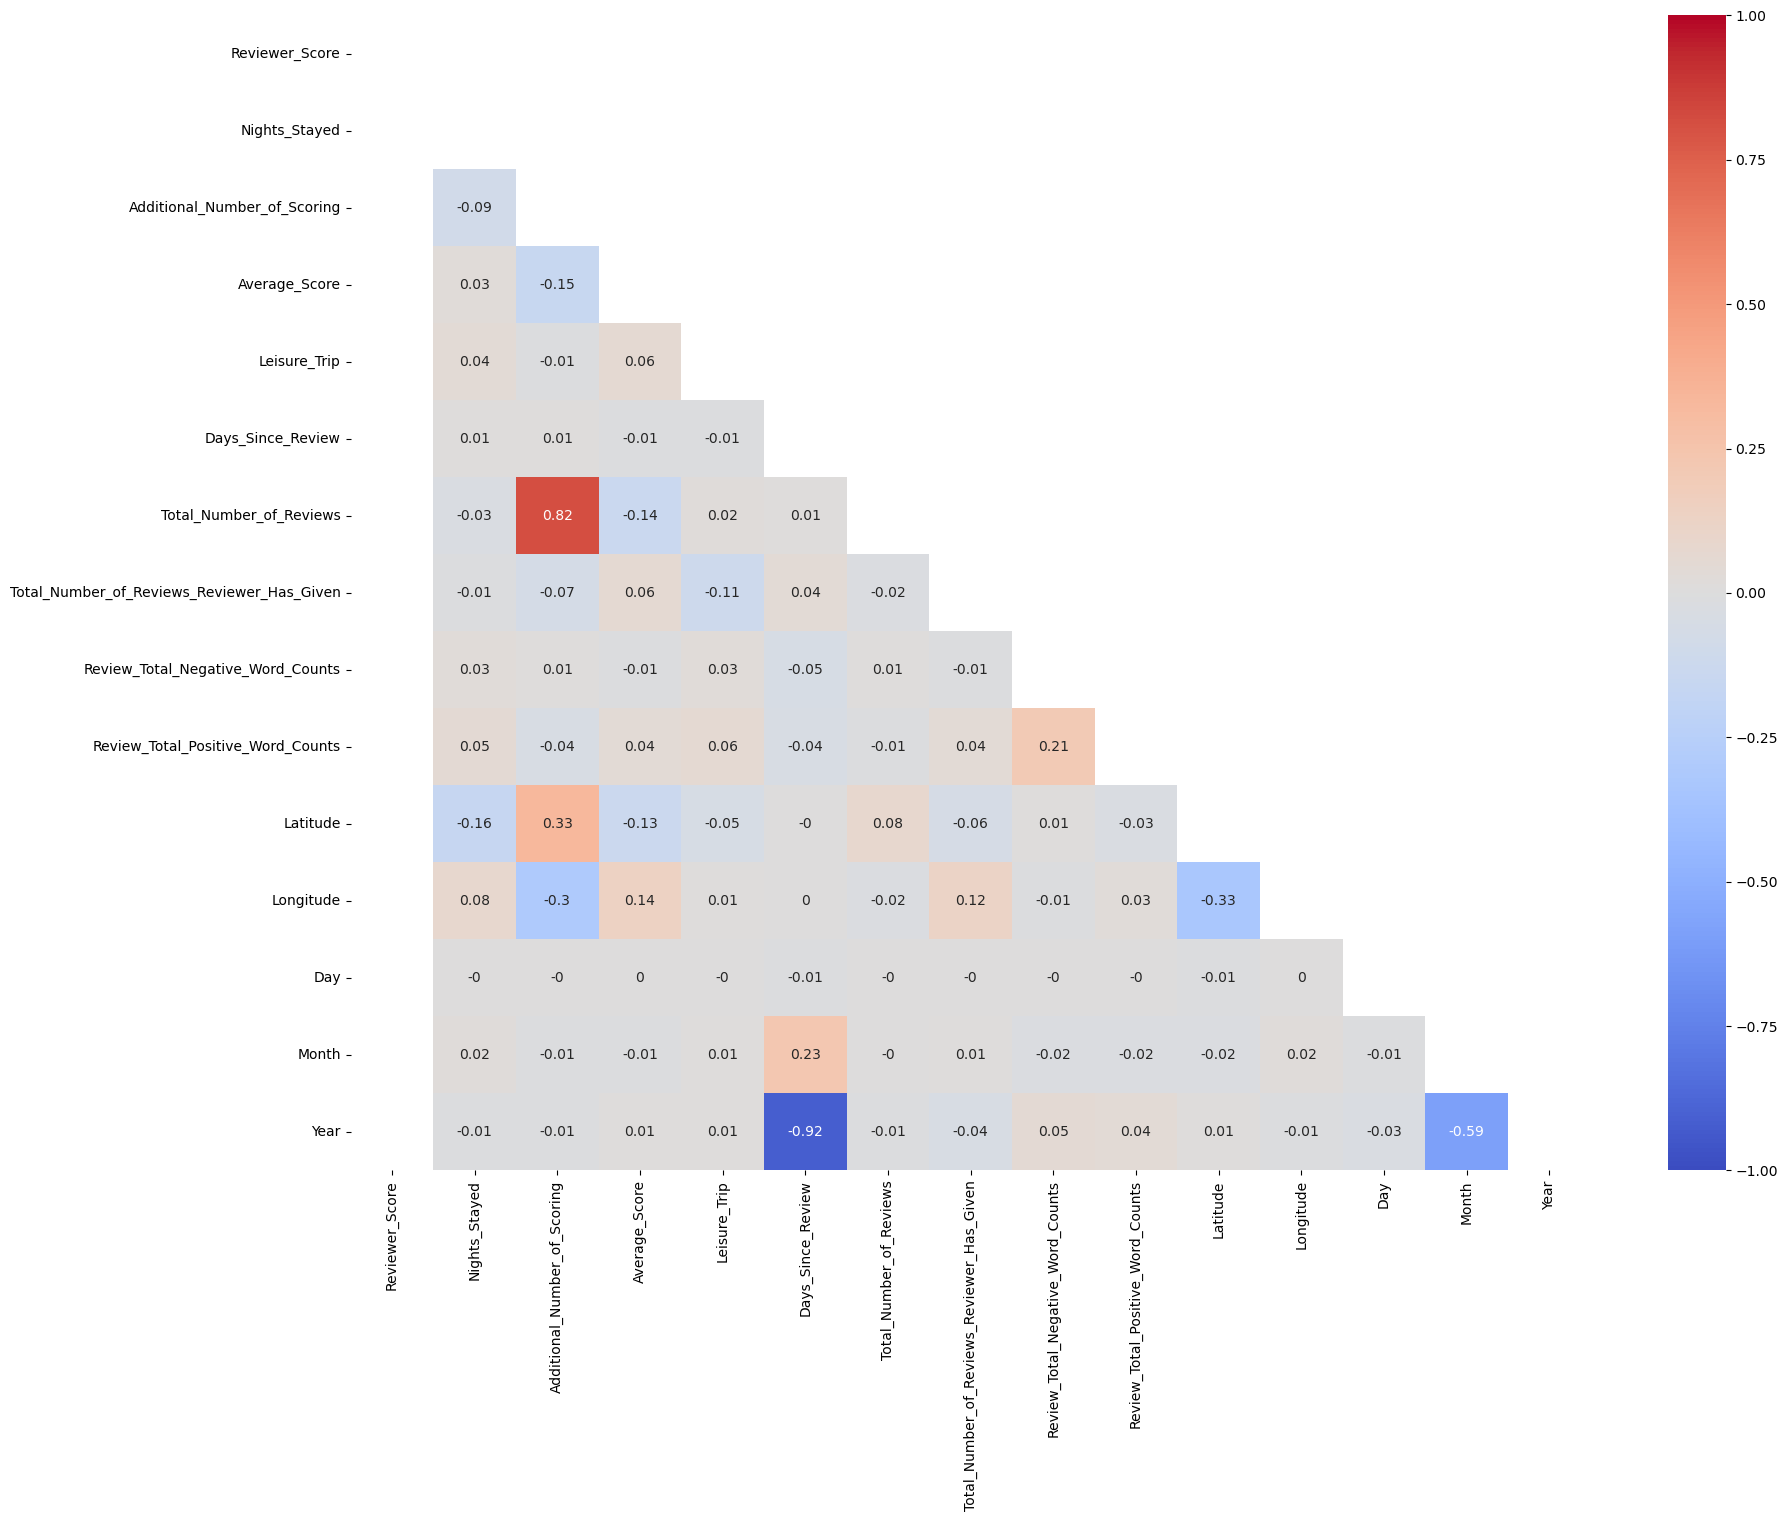

In [56]:
# Correlations for independent variables
indcorr=inverse_hotel_nd_nreviews.corr()
#Heatmap
mask=np.triu(indcorr)
plt.figure(figsize=(20,15))
sns.heatmap(indcorr.round(2), vmax=1,vmin=-1,center=0,cmap='coolwarm',mask=mask, annot=True)
plt.show

**Correlation Heatmaps**

It's interesting to see. When the data is evaluated as an independent set, there is some correlation among variables.
It's intuitive that a positive reviewer score is correlated to higher average scores, you don't see the inverse relationship with negative reviewer scores. 
Some notes:
- Most significant features:
    - Days Since Reviews ~ Year
    - Total # Reviews ~ Additional Number of Scoring


In [57]:
#### Looking at PCA
### Target 

In [58]:
hotel.Total_Number_of_Reviews_Reviewer_Has_Given.describe()	

count    515199.000000
mean          7.164750
std          11.039315
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: Total_Number_of_Reviews_Reviewer_Has_Given, dtype: float64

In [59]:
hotel[hotel.Reviewer_Score==1].Average_Score.describe()

count    293715.000000
mean          8.555110
std           0.494474
min           5.200000
25%           8.200000
50%           8.600000
75%           8.900000
max           9.800000
Name: Average_Score, dtype: float64

<Axes: >

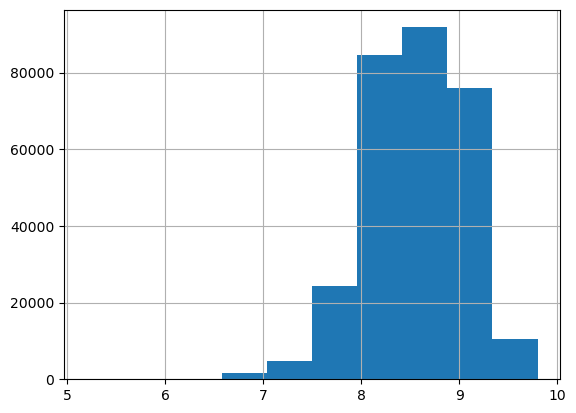

In [60]:
plt.figure()
hotel[hotel.Reviewer_Score==1].Average_Score.hist()
#plt.axvline(x=hotel[hotel.Reviewer_Score==1].mean())

<Axes: xlabel='Average_Score', ylabel='Count'>

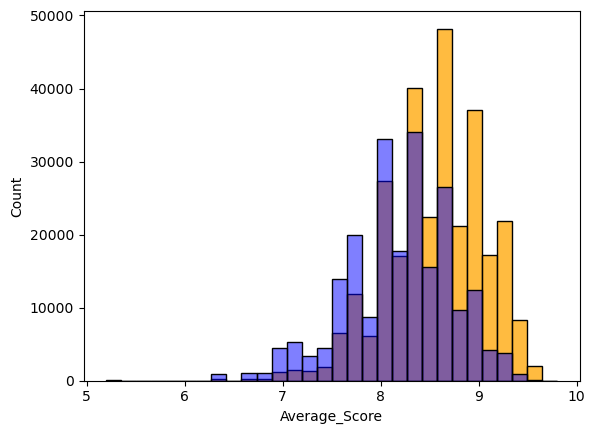

In [61]:
sns.histplot(hotel[hotel.Reviewer_Score==1].Average_Score, bins=30,color='orange')
sns.histplot(hotel[hotel.Reviewer_Score==0].Average_Score,bins=30, alpha=0.5,color='blue')

Text(0.5, 1.0, 'Mirror Distribution of Negative and Positive Word Counts')

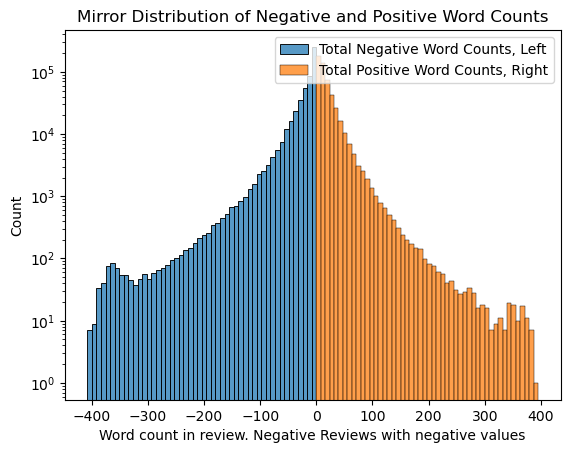

In [62]:
sns.histplot(-hotel.Review_Total_Negative_Word_Counts, label='Total Negative Word Counts, Left', bins=50)
sns.histplot(hotel.Review_Total_Positive_Word_Counts,label='Total Positive Word Counts, Right',bins=50)
plt.yscale('log')
plt.xlabel('Word count in review. Negative Reviews with negative values')
plt.legend()
plt.title('Mirror Distribution of Negative and Positive Word Counts')

In [63]:
#Perhaps unnecessary but I thuoght it might be a good way to visualize any difference
#Between the two. Except 

In [64]:
#


#hotel[hotel.Reviewer_Score==1].Average_Score.hist()
#sns.histplot(hotel[hotel.Reviewer_Score==1].Average_Score.hist()

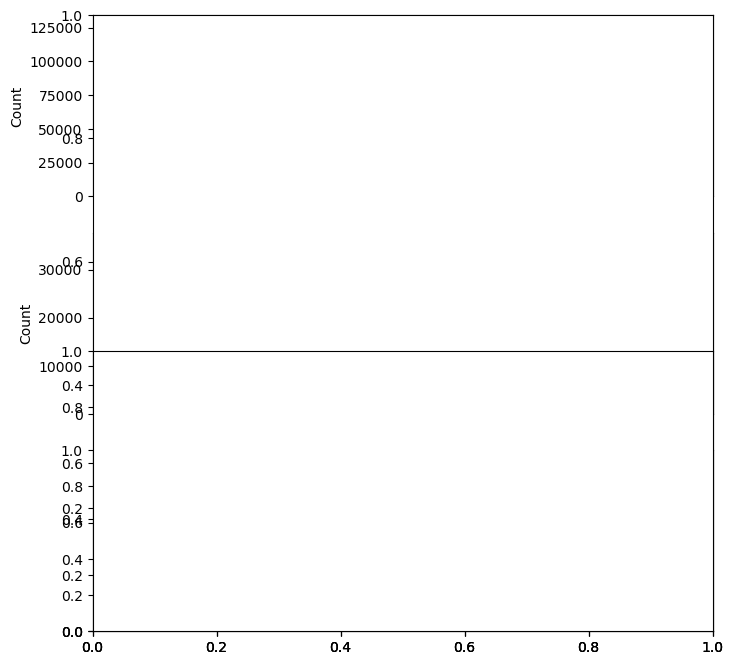

In [65]:
# Create a sample DataFrame


# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))

# Plot each column on a separate subplot
ax1 = plt.subplot(1,1,1)
sns.histplot(hotel.Review_Total_Negative_Word_Counts,ax=axes[0])

plt.subplot(2,1,2)
sns.histplot(hotel.Review_Total_Positive_Word_Counts,ax=axes[1])

#plt.subplot(313)
#sns.histplot(hotel.Total_Number_of_Reviews_Reviewer_Has_Given)#(ax=axes[2])

plt.show()


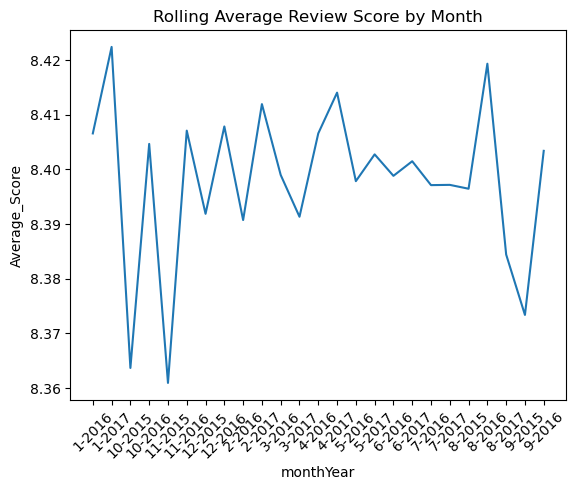

In [66]:
sns.lineplot(AverageReviews.groupby('monthYear')['Average_Score'].mean())
plt.xticks(rotation=45)
plt.title('Rolling Average Review Score by Month')
plt.show()

In [67]:
#hotel.groupby(hotel.pd.dt.Month.str+hotel.month.dt.str['Average_Score'].count())

<Axes: xlabel='Average_Score', ylabel='Count'>

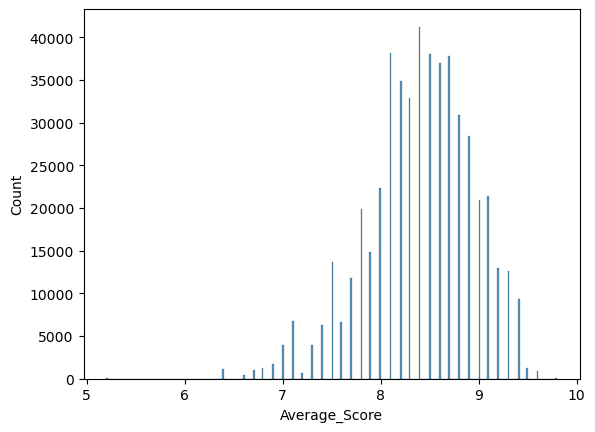

In [68]:
sns.histplot(hotel.Average_Score)

(array([6.50000e+01, 0.00000e+00, 1.16300e+03, 8.30400e+03, 1.77580e+04,
        6.69720e+04, 1.69404e+05, 1.43642e+05, 9.64020e+04, 1.14890e+04]),
 array([5.2 , 5.66, 6.12, 6.58, 7.04, 7.5 , 7.96, 8.42, 8.88, 9.34, 9.8 ]),
 <BarContainer object of 10 artists>)

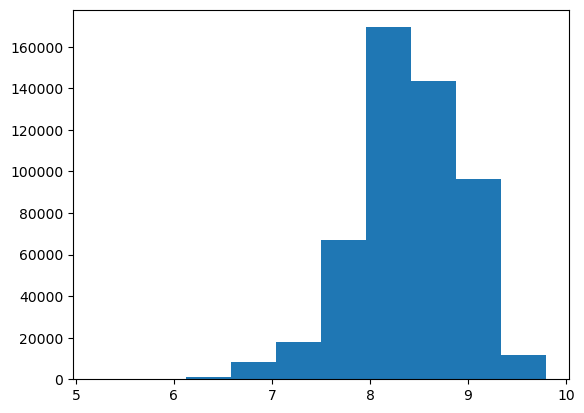

In [69]:
plt.hist(hotel.Average_Score)

(8.2, 8.6)

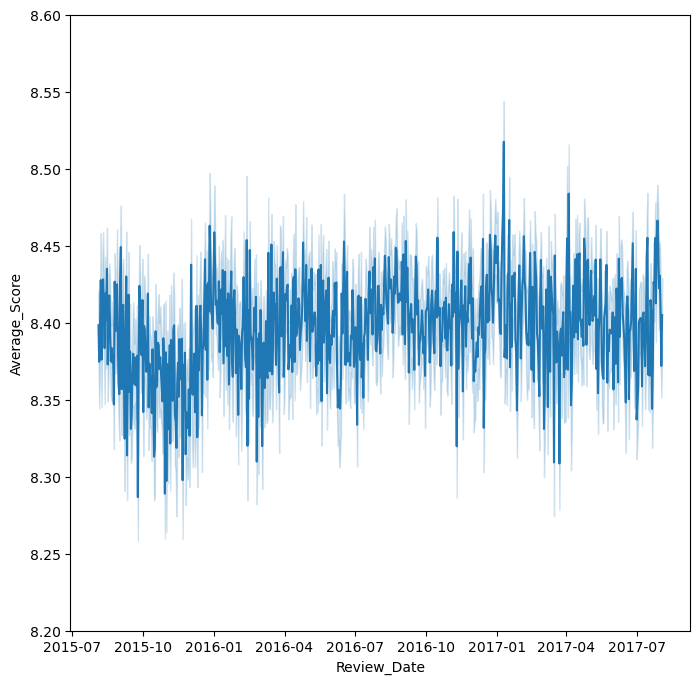

In [70]:
plt.figure(figsize=(8,8))
sns.lineplot(x=AverageReviews.Review_Date,y=AverageReviews.Average_Score)
plt.ylim(8.2,8.6)

In [71]:
AverageReviews.head(1)

,Review_Date,level_1,Average_Score,Average_Score_std,monthYear
0,2015-08-04,244,NaN,NaN,8-2015


In [72]:
AverageReviews['smoothed_value'] = AverageReviews['Average_Score'].rolling(window=5).mean()
AverageReviews.head(4)

,Review_Date,level_1,Average_Score,Average_Score_std,monthYear,smoothed_value
0,2015-08-04,244,NaN,NaN,8-2015,NaN
1,2015-08-04,403,NaN,NaN,8-2015,NaN
2,2015-08-04,404,NaN,NaN,8-2015,NaN
3,2015-08-04,1373,NaN,NaN,8-2015,NaN


In [73]:
AverageReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515199 entries, 0 to 515198
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Review_Date        515199 non-null  datetime64[ns]
 1   level_1            515199 non-null  int64         
 2   Average_Score      512275 non-null  float64       
 3   Average_Score_std  0 non-null       float64       
 4   monthYear          515199 non-null  object        
 5   smoothed_value     509351 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 23.6+ MB


In [74]:
hotel.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,1,1,0,0,0,0,0,2017-08-03


In [75]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515199 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Reviewer_Score                              515199 non-null  int64         
 1   Nights_Stayed                               515199 non-null  int64         
 2   Positive_Review                             515199 non-null  object        
 3   Negative_Review                             515199 non-null  object        
 4   Additional_Number_of_Scoring                515199 non-null  int64         
 5   Average_Score                               515199 non-null  float64       
 6   Leisure_Trip                                515199 non-null  int64         
 7   Days_Since_Review                           515199 non-null  int64         
 8   Total_Number_of_Reviews                     515199 non-null  int64         
 9 

fig, ax = plt.subplots(nrows=2, ncol=1)
plt.subplot(111)
sns.lineplot(x=hotel.Nights_Stayed,y=hotel.Average_Score)

plt.subplot(212)
sns.histplot(hotel.Nights_Stayed)


<Axes: xlabel='Review_Date', ylabel='Average_Score'>

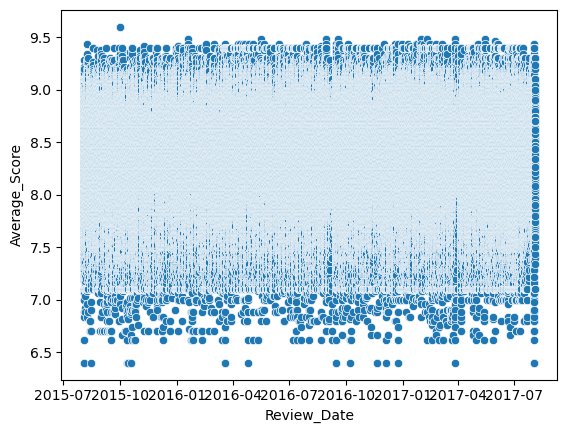

In [76]:
sns.scatterplot(x=AverageReviews.Review_Date,y=AverageReviews.Average_Score)


In [77]:
hotel.Review_Date.unique()

<DatetimeArray>
['2017-08-03 00:00:00', '2017-07-31 00:00:00', '2017-07-24 00:00:00',
 '2017-07-17 00:00:00', '2017-07-09 00:00:00', '2017-07-08 00:00:00',
 '2017-07-07 00:00:00', '2017-07-06 00:00:00', '2017-07-04 00:00:00',
 '2017-07-03 00:00:00',
 ...
 '2017-06-03 00:00:00', '2017-01-05 00:00:00', '2016-09-21 00:00:00',
 '2016-09-14 00:00:00', '2017-05-12 00:00:00', '2017-07-28 00:00:00',
 '2017-07-23 00:00:00', '2017-07-27 00:00:00', '2017-04-29 00:00:00',
 '2017-07-15 00:00:00']
Length: 731, dtype: datetime64[ns]

In [78]:
#AverageReviews.to_frame().info()

In [79]:
#plt.plot(hotel.Review_Date.value(),hotel.groupby('Review_Date').Review_Date.count())

In [80]:
#plt.scatter(hotel.Review_Date,hotel.groupby('Review_Date').Average_Score.mean())

In [81]:
#plt.plot(hotel.Review_Date,hotel[hotel.Reviewer_Score==1].count())

In [82]:
#sns.lineplot(x=hotel.Review_Date,y=hotel[hotel.Reviewer_Score==1].count())

In [83]:
hotel.describe()

,Reviewer_Score,Nights_Stayed,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
count,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,...,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199
mean,0.570100,2.361750,498.417604,8.397776,0.810070,354.402120,2744.691424,7.164750,18.540711,17.778489,...,0.475752,0.068612,0.365010,0.111043,0.116747,0.509110,0.072209,0.115319,0.075573,2016-08-13 14:20:56.802129152
min,0.000000,1.000000,1.000000,5.200000,0.000000,0.000000,43.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015-08-04 00:00:00
25%,0.000000,1.000000,169.000000,8.100000,1.000000,175.000000,1161.000000,1.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016-02-23 00:00:00
50%,1.000000,2.000000,342.000000,8.400000,1.000000,353.000000,2134.000000,3.000000,9.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2016-08-15 00:00:00
75%,1.000000,3.000000,660.000000,8.800000,1.000000,527.000000,3633.000000,8.000000,23.000000,22.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2017-02-09 00:00:00
max,1.000000,31.000000,2682.000000,9.800000,1.000000,730.000000,16670.000000,355.000000,408.000000,395.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017-08-03 00:00:00
std,0.495062,1.646734,500.673193,0.547947,0.392246,208.909135,2318.112418,11.039315,29.693602,21.804665,...,0.499412,0.252794,0.481434,0.314185,0.321119,0.499917,0.258834,0.319406,0.264314,NaN


In [84]:
hotel.Review_Total_Positive_Word_Counts

0          11
1         105
2          21
3          26
4           8
         ... 
515733      2
515734     11
515735      0
515736     25
515737      6
Name: Review_Total_Positive_Word_Counts, Length: 515199, dtype: int64

In [85]:
# positive word count per negative review
print('Number of Words in Negative Reviews: ',hotel.Review_Total_Negative_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('Number of Words in Positive Reviews: ',hotel.Review_Total_Positive_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
# negative word count per negative review

Number of Words in Negative Reviews:  43.127973126726985
Number of Words in Positive Reviews:  31.184856067957032


In [86]:
(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count())/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count())

1.3261228802080511

In [87]:
hotel.Review_Date

0        2017-08-03
1        2017-08-03
2        2017-07-31
3        2017-07-31
4        2017-07-24
            ...    
515733   2015-08-30
515734   2015-08-22
515735   2015-08-19
515736   2015-08-17
515737   2015-08-09
Name: Review_Date, Length: 515199, dtype: datetime64[ns]

In [88]:
hotel.shape

(515199, 30)

Reviewer_Score
1    293715
0    221484
Name: count, dtype: int64


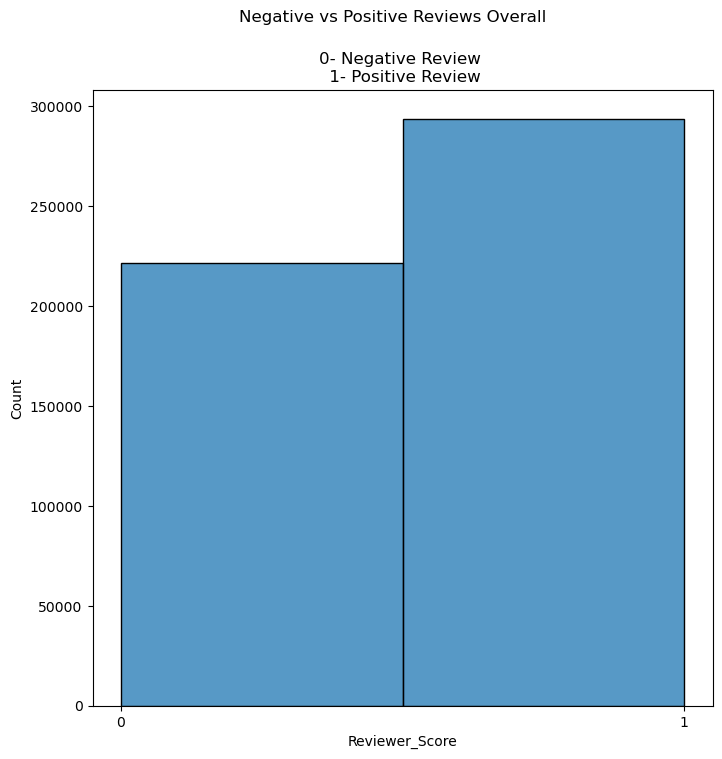

In [89]:
print(hotel.Reviewer_Score.value_counts())
plt.figure(figsize=(8,8))
sns.histplot(hotel.Reviewer_Score, bins=2)
plt.xticks(np.arange(0, 1.1, step=1))
plt.suptitle('Negative vs Positive Reviews Overall')
plt.title('0- Negative Review \n 1- Positive Review')
plt.show()

Pretty simple here - generally positive reviews.

Text(0.5, 0, 'Average Score')

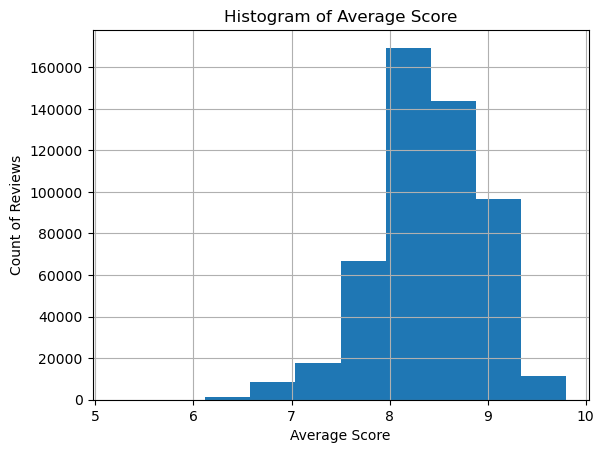

In [90]:
plt.figure()
hotel.Average_Score.hist()
plt.title("Histogram of Average Score")
plt.ylabel('Count of Reviews')
plt.xlabel('Average Score')

In [91]:
hotel.head(3)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,1,1,0,0,0,0,0,2017-08-03
1,0,4,No real complaints the hotel was great great ...,No Negative,194,7.7,1,0,1403,7,...,0,0,0,1,0,0,0,0,0,2017-08-03
2,0,3,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,194,7.7,1,3,1403,9,...,0,0,0,1,0,0,0,0,0,2017-07-31


<Axes: >

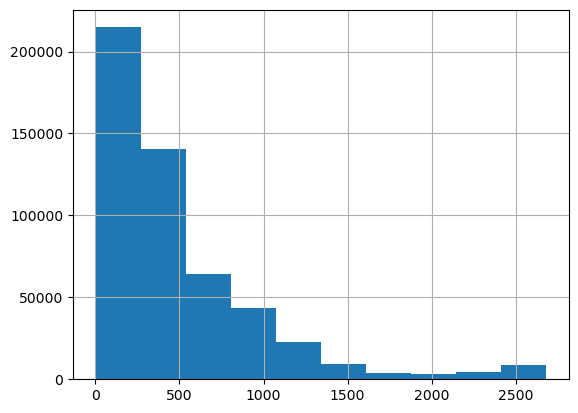

In [92]:
plt.subplot(111)
hotel.Additional_Number_of_Scoring.hist()

18.54071145324428
9552156


<Axes: >

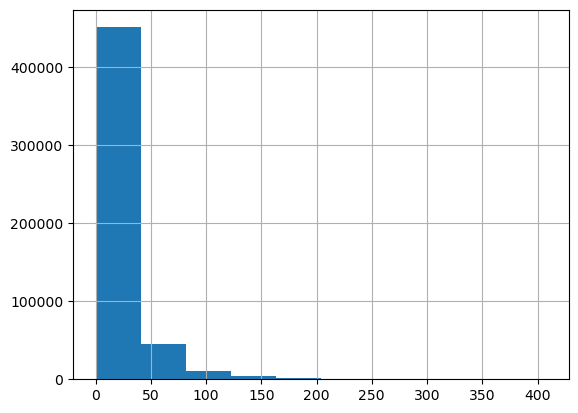

In [93]:
print(hotel.Review_Total_Negative_Word_Counts.mean())
print(hotel.Review_Total_Negative_Word_Counts.sum())
hotel.Review_Total_Negative_Word_Counts.hist()

17.77848947688175
9159460


<Axes: >

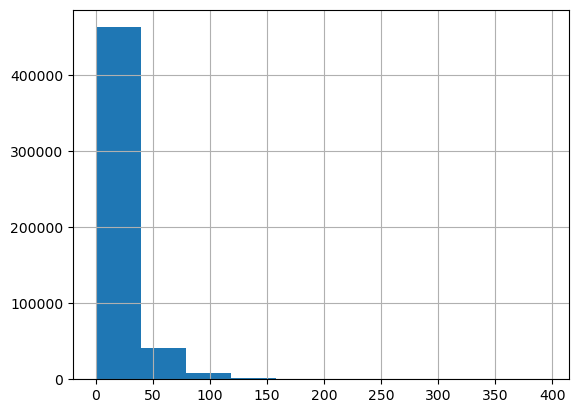

In [94]:
print(hotel.Review_Total_Positive_Word_Counts.mean())
print(hotel.Review_Total_Positive_Word_Counts.sum())
hotel.Review_Total_Positive_Word_Counts.hist()

In [95]:
hotel.describe()

,Reviewer_Score,Nights_Stayed,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
count,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,...,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199
mean,0.570100,2.361750,498.417604,8.397776,0.810070,354.402120,2744.691424,7.164750,18.540711,17.778489,...,0.475752,0.068612,0.365010,0.111043,0.116747,0.509110,0.072209,0.115319,0.075573,2016-08-13 14:20:56.802129152
min,0.000000,1.000000,1.000000,5.200000,0.000000,0.000000,43.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015-08-04 00:00:00
25%,0.000000,1.000000,169.000000,8.100000,1.000000,175.000000,1161.000000,1.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016-02-23 00:00:00
50%,1.000000,2.000000,342.000000,8.400000,1.000000,353.000000,2134.000000,3.000000,9.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2016-08-15 00:00:00
75%,1.000000,3.000000,660.000000,8.800000,1.000000,527.000000,3633.000000,8.000000,23.000000,22.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2017-02-09 00:00:00
max,1.000000,31.000000,2682.000000,9.800000,1.000000,730.000000,16670.000000,355.000000,408.000000,395.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017-08-03 00:00:00
std,0.495062,1.646734,500.673193,0.547947,0.392246,208.909135,2318.112418,11.039315,29.693602,21.804665,...,0.499412,0.252794,0.481434,0.314185,0.321119,0.499917,0.258834,0.319406,0.264314,NaN


In [96]:
min(hotel.Average_Score)
max(hotel.Average_Score)

9.8

In [97]:
hotel.shape

(515199, 30)

## Question 2: Text Pre-Processing <a class="anchor" name="Part2"></a>
TT-Split Now <br>
Check CountVectorizer doc. about tokenization procedures - what might it be skipping that's covered below?
- lowercase must be specified
- special characters and punctuation auto
- split auto.
- *****StopWords

<div class="alert alert-block alert-warning">
<b>QUESTION 2 TEXT:</b><p style="color:black;"><b></b><br>
Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following: <br>
- What tokenizer and text cleaning steps do you include?<br>
- Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.
    
<p style="color:red;">This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).
</b></p></div>

##### Part 0: Insights, maybe useless. revisit after

In [98]:
print('Number of Words in Negative Reviews: ',hotel.Review_Total_Negative_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('Number of Words in Positive Reviews: ',hotel.Review_Total_Positive_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))

Number of Words in Negative Reviews:  43.127973126726985
Number of Words in Positive Reviews:  31.184856067957032


In [99]:
hotel.Review_Total_Negative_Word_Counts.describe()
hotel.iloc[1,3]

'No Negative'

In [100]:
x=len(hotel.index)*.9
x=round(x,0)
#hotel.Review_Total_Negative_Word_Counts.iloc[hotel.Review_Total_Negative_Word_Counts.index.max*.9]

In [101]:
int(x)

463679

In [102]:
hotel.Review_Total_Negative_Word_Counts.sort_values(ascending=True).iloc[int(x)]

46

##### Histograms of Positive and Negative Word Counts

count    515199.000000
mean         18.540711
std          29.693602
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: Review_Total_Negative_Word_Counts, dtype: float64


<Axes: >

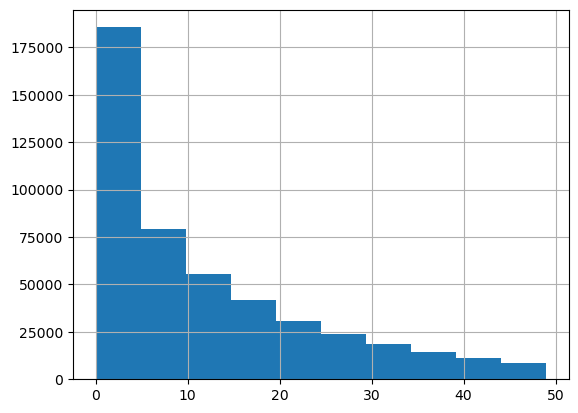

In [103]:
#  >90 % Positive Review word counts covered by values of 50 or less

print(hotel.Review_Total_Negative_Word_Counts.describe())
hotel[hotel.Review_Total_Negative_Word_Counts<50].Review_Total_Negative_Word_Counts.hist()

count    515199.000000
mean         17.778489
std          21.804665
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: Review_Total_Positive_Word_Counts, dtype: float64


<Axes: >

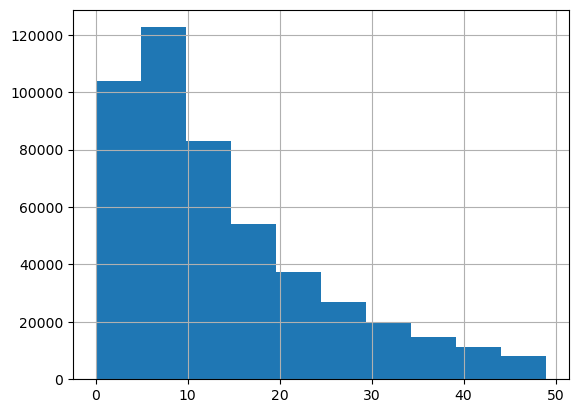

In [104]:
#  Over of 90 % Positive Review word counts covered by values of 50 or less
print(hotel.Review_Total_Positive_Word_Counts.describe())
hotel[hotel.Review_Total_Positive_Word_Counts<50].Review_Total_Positive_Word_Counts.hist()

##### Part 0: Gibberish Insight for later, if any reason

In [105]:
## Review of avaialble basic df for use
# hotel - full set with dummies
# hotel_pos - positive reviews with dummies
# hotel_neg - negative reviews with dummies
# hotel_nd - full no dummies
# hotel_nd_nreviews - no dummies no reviews

In [106]:
import string
import re

In [107]:
hotel.Positive_Review.str.split(pat=' ').apply(len).describe()

count    515199.000000
mean         17.917824
std          21.696735
min           1.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: Positive_Review, dtype: float64

In [108]:
hotel.Review_Total_Positive_Word_Counts.describe()

count    515199.000000
mean         17.778489
std          21.804665
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: Review_Total_Positive_Word_Counts, dtype: float64

In [109]:
hotel.Negative_Review.str.split(pat=' ').apply(len).describe()

count    515199.000000
mean         19.036640
std          29.395001
min           1.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: Negative_Review, dtype: float64

In [110]:
hotel.Review_Total_Negative_Word_Counts.describe()

count    515199.000000
mean         18.540711
std          29.693602
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: Review_Total_Negative_Word_Counts, dtype: float64

In [111]:
### Values seem to match up for the most part. Off by a fraction of a word here or there.

In [112]:
hotel_pos=hotel[hotel.Reviewer_Score==1]
hotel_neg=hotel[hotel.Reviewer_Score==0]

In [113]:
# Taking a subsample of 20% to test
hotel_sub=hotel.sample(frac=0.2)

##### Part 0b, roll it up there~ish: Fx, cleaning proc., review

In [114]:

import re

def custom_tokenizer(text):
    """
    Custom tokenizer function.
    """
    # lower text
    text = text.lower()

    # remove special characters using regex substitution by the empty string
    text = re.sub(f"[{forbidden_char}]", "", text)

    # then split into words as tokens
    tokens = text.split()

    # stopwords
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]

    return tokens

**Custom Tokenizer VS CountVectorizer for _cleaning_.
It's seen later that CountVectorizer doesn't do things perfectly - there are still errors.
<br>
Steps covered by Vectorizer:
    - lower case standardization
    - special characters
    
There are a couple extra steps that can be stated - though it might grow:
    - ngrams OR nullifying
    - stop words
    -

In [115]:
#hotel_pos.Positive_Review.apply(customer_tokenizer)

In [116]:
#hotel_pos.Positive_Review.str.apply(custom_tokenizer)

In [117]:
#Special characters are handled by Vectorizer, not needed here in custom tokenizer
#re.sub(f"[{forbidden_char}]",'','testing2323.')

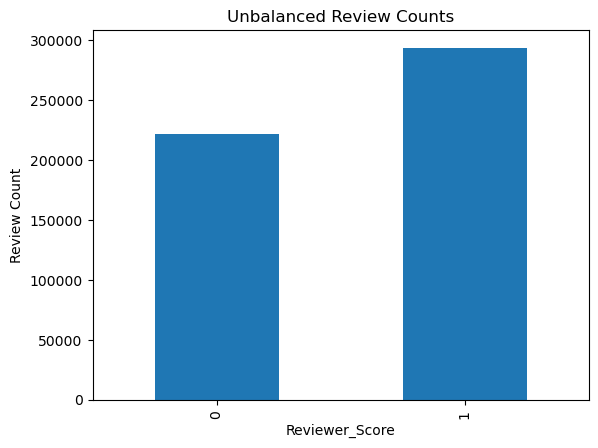

In [118]:
# Class Imbalance
hotel.groupby('Reviewer_Score').Reviewer_Score.count().plot(kind='bar')
plt.ylabel('Review Count')
plt.title('Unbalanced Review Counts')
plt.show()

In [119]:
print('Positive Review: ',(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
print('Negative Review: ',(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('%Difference: ',round(((hotel[hotel.Reviewer_Score==1].Reviewer_Score.count())/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count())-1)*100,2),'%')

Positive Review:  293715
Negative Review:  221484
%Difference:  32.61 %


In [120]:
# Evaluating relative to the custom tokenizer already made in class -

In [121]:
## The only step I can think of here is to address the "No Positive" or "No Negative"
## Review values because those will have quite a few

### Part 1: TT Split

In [122]:
y=hotel.Reviewer_Score.astype(dtype='string')

In [123]:
# Assign target and X
X=hotel
y=hotel.Reviewer_Score

## Train - Test Split. Test size = 20%. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
X_train_pos=X_train.Positive_Review
X_test_pos=X_test.Positive_Review

In [125]:
X_train_neg=X_train.Negative_Review
X_test_neg=X_test.Negative_Review

In [126]:
# Sanity Check
print(hotel.shape)
print(X.shape)
print(y.shape)

(515199, 30)
(515199, 30)
(515199,)


In [127]:
print('train_pos:',X_train_pos.shape)
print('test_pos:',X_test_pos.shape)
print('train_neg:',X_train_neg.shape)
print('test_neg:',X_test_neg.shape)

train_pos: (412159,)
test_pos: (103040,)
train_neg: (412159,)
test_neg: (103040,)


In [128]:
X_train_pos

451308     The feel good atmosphere specially in the lob...
499431                       comfortable bed good breakfast
469987                               Location is excellent 
98529      Excellent service from the staff and I always...
372343     Modern look and good design of hotel building...
                                ...                        
259652                                   Location and staff
366367                          The room was very charming 
131967                                         the location
146902              Offers everything a 5 star hotel offers
121993     Friendly staff Jessica was a great help with ...
Name: Positive_Review, Length: 412159, dtype: object

In [129]:
X_train_neg

451308                                          No Negative
499431                    would like resaurant in the hotel
469987     But overall run down hotel with poor faciliti...
98529          Nothing it s always a pleasure to stay here 
372343     Immediate neighborhood lacking of appeal and ...
                                ...                        
259652     rooms view furniture not enough and area very...
366367             The staff were not friendly and helpful 
131967        The shower was blocked and room was very damp
146902                              Small rooms and hot a c
121993                                          No Negative
Name: Negative_Review, Length: 412159, dtype: object

<div class="alert alert-block alert-info"><p style="color: red;">
<b>Review:</b> Review how zero or null reviews are represented - do they need to be accounted for?
    What words are covered in the STOP words? Define vocab? Refine later.
</p></div>

### Part 2: Preprocessing, Text Cleaning, Tokenizer/Vectori

In [130]:
#hotel_sub.Positive_Review

This is the basic process at least. Ask questions of Stephen as best as you can articulate:
<br>need to ask a few questions beforehand to make sure I'm ready to be more specific

- Cleaning via Vectorizer vs Customer
- Need to make sure cleaning process is addressed appropriately - i.e. 'No Positive' or n/A!




In [131]:
X_train, X_test, y_train, y_test = train_test_split(
    hotel[['Positive_Review','Negative_Review']],
    hotel['Reviewer_Score'], 
    test_size=0.2, random_state=42)

#### small_reviews=pd.DataFrame({'pos_y_test':y_test})

In [132]:
X_train

,Positive_Review,Negative_Review
451308,The feel good atmosphere specially in the lob...,No Negative
499431,comfortable bed good breakfast,would like resaurant in the hotel
469987,Location is excellent,But overall run down hotel with poor faciliti...
98529,Excellent service from the staff and I always...,Nothing it s always a pleasure to stay here
372343,Modern look and good design of hotel building...,Immediate neighborhood lacking of appeal and ...
...,...,...
259652,Location and staff,rooms view furniture not enough and area very...
366367,The room was very charming,The staff were not friendly and helpful
131967,the location,The shower was blocked and room was very damp
146902,Offers everything a 5 star hotel offers,Small rooms and hot a c


In [133]:
X_test

,Positive_Review,Negative_Review
481401,Perfect location for all needs Walking distan...,No coment everything perfect
423926,No Positive,It s not a 4 star hotel more like a 3 star
154881,The room was good and spacious cleaned everyd...,location of hotel distant from nearest metro ...
279350,Comfortable stay all the facilities you could...,No Negative
288003,Amazing location Lovely room,Drilling in the next room was so loud Despite...
...,...,...
509741,The staff were amazing and couldn t do enough...,No faults to report We enjoyed our stay immen...
167706,friendly reception great location Room itself...,horrid pillows and bed very hard Room cold
503215,I loved the actual hotel the room was lovely ...,The main receptionist was very rude at check ...
313142,I stayed for a week and i didn t feel like i ...,My room was noisy it was close to the street ...


In [134]:
X_test

,Positive_Review,Negative_Review
481401,Perfect location for all needs Walking distan...,No coment everything perfect
423926,No Positive,It s not a 4 star hotel more like a 3 star
154881,The room was good and spacious cleaned everyd...,location of hotel distant from nearest metro ...
279350,Comfortable stay all the facilities you could...,No Negative
288003,Amazing location Lovely room,Drilling in the next room was so loud Despite...
...,...,...
509741,The staff were amazing and couldn t do enough...,No faults to report We enjoyed our stay immen...
167706,friendly reception great location Room itself...,horrid pillows and bed very hard Room cold
503215,I loved the actual hotel the room was lovely ...,The main receptionist was very rude at check ...
313142,I stayed for a week and i didn t feel like i ...,My room was noisy it was close to the street ...


In [135]:
# There are data rows were Positive Reviews are actually blank but entered (by whomsoever created the csv) as 'No Positive'
# A decision needs to be made on how to handle them - and before the train test split
hotel[hotel.Positive_Review.str.contains('Positive') & hotel.Reviewer_Score==1].head()

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
333,1,3,No Positive,Restaurant was expensive,194,7.7,1,494,1403,6,...,1,0,0,1,0,0,0,0,0,2016-03-27
496,1,2,No Positive,there where waterpipes near the room it sound...,244,8.5,1,286,1831,8,...,0,0,1,0,0,1,0,0,0,2016-10-21
753,1,3,No Positive,Bathrooms very small,244,8.5,1,279,1831,1,...,0,0,1,0,0,1,0,0,0,2016-10-28
763,1,2,No Positive,The breads at breakfast were not as fresh as ...,244,8.5,0,321,1831,2,...,1,0,0,0,0,1,0,0,0,2016-09-16
840,1,2,No Positive,we didn t dislike anything,244,8.5,1,492,1831,1,...,1,0,0,0,0,1,0,0,0,2016-03-29


In [136]:
# Make a copy in case hotel df needs to be reset

#hotel2=hotel.copy()
hotel=hotel2.copy()



In [137]:
# For Positive Review: Removing what should be blank cells
print(hotel[hotel['Positive_Review'].str.contains('No Positive')].Positive_Review.count())
print(hotel[hotel['Positive_Review'].str.contains('No Negative')].Positive_Review.count())
print(hotel[hotel['Negative_Review'].str.contains('No Positive')].Negative_Review.count())
print(hotel[hotel['Negative_Review'].str.contains('No Negative')].Negative_Review.count())
#print(hotel[hotel[['Negative_Review'].str.contains('No Positive')])
#hotel[hotel['Negative_Review'].str.contains('No Negative' or 'No Positive')].head(5)
#hotel[hotel['Positive_Review'].str.contains('No Negative' or 'No Positive')].head(5)

#hotel[hotel.Positive_Review.str.contains('Negative' or 'Positive"')].value_counts().sum()#[hotel.Positive_Review]#hotel.Negative_Review.str.contains() #or hotel[hotel['Negative_Review'].str.contains('No Positive')]).count())
#hotel[hotel.Negative_Review.str.contains('Negative' or 'Positive"')].value_counts().sum()

#print('No Negative in review columns: ',hotel.Negative_Review[hotel.Negative_Review.str.contains('No Negative')].count())

35901
0
0
127758


In [138]:
# Got rid of words that were skewing results
hotel[hotel['Positive_Review'].str.contains('No Positive')]=''
hotel[hotel['Negative_Review'].str.contains('No Negative')]=''


In [139]:
#mapping={'No Positive':'','No Negative':''}
#print(hotel[hotel['Positive_Review'].str.contains('No Positive')].Positive_Review.value_counts())
hotel[hotel['Positive_Review'].str.contains('No Positive')].Positive_Review
hotel[hotel['Negative_Review'].str.contains('No Negative')].Negative_Review

Series([], Name: Negative_Review, dtype: object)

In [140]:
print(hotel[hotel['Positive_Review'].str.contains('No Positive')].Positive_Review.value_counts())

Series([], Name: count, dtype: int64)


In [141]:
hotel[hotel['Positive_Review'].str.contains('No Negative','No Positive')].head(5)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna


<Axes: >

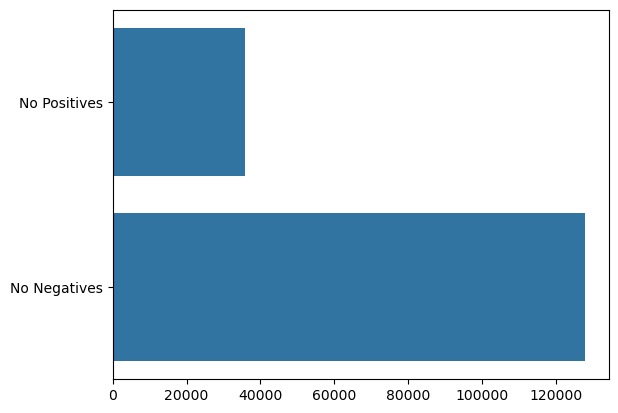

In [142]:
quick_bar=[35910,127758]
names=['No Positives','No Negatives']
sns.barplot(x=quick_bar,y=names)

#plot(kind='bar')

In [143]:
# There are a huge number of cells that should be blank
# An entry of 'No Positive' or 'No Negative' will cause issues with word frequency --
#      and that goes for both review columnn

After an initial run through the process, I came out with a top 'postive' predictor of "trouble" which doesn't quite make sense.
So I'm going to take a look into here.

In [144]:
pd.options.display.width = 0

In [145]:

hotel[hotel['Positive_Review'].str.contains('trouble')].Positive_Review.to_frame().reset_index().rename(columns=({'index':'row'}))    

,row,Positive_Review
0,35,Very nice hotel manager he upgraded us becaus...
1,459,The staff are really helpful and accommodatin...
2,1204,Great location Check in staff and concierge w...
3,1226,Staff are very friendly and nothing is too mu...
4,1254,Fantastic hotel with great staff and faciliti...
...,...,...
1308,513402,Nice spacious hotel food was excellent in the...
1309,513582,A very convenient location cleanliness fantas...
1310,513607,What not to like Clean comfortable spacious E...
1311,513626,Nothing was too much trouble the travel cot w...


In [146]:
#for x in 10:
trouble_df=hotel[hotel['Positive_Review'].str.contains('trouble')].Positive_Review.to_frame().reset_index().rename(columns=({'index':'row'}))

In [147]:
for x in range(10):
    print(trouble_df.Positive_Review.loc[x],'\n')

 Very nice hotel manager he upgraded us because we had troubles with two different rooms They do everything to make you feel welcome and comfortable The park directly in front of the hotel is amazing rent a bike directly and make a tour Also the bathtub and bed is great  

 The staff are really helpful and accommodating Nothing was too much trouble The hotel is very pretty in a great location with a cosy bar area I have stayed here several times and will definitely stay again  

 Great location Check in staff and concierge were so polite and helpful we felt nothing was too much trouble and very genuine The room was spotless and facilities excellent A very quiet room and bed was extremely comfortable which meant we slept very well  

 Staff are very friendly and nothing is too much trouble Rooms have everything you need very clean and comfortable Very quiet Love the Ducks Second stay at this hotel last was at christmas Stayed in the same room Comfortable walking distance to St Paul s So

The most repetitive phrase, having looked at the 10 first sentences with "trouble" are the exact same. That's 5 words in a row. Going to use n-grams at a length of 5 to compensate for these pesky troubles.
Regarding the phrase _"Nothing was too much trouble"_ , it is a positive phrase and it comes up the most impacting phrase to the model.

As far as a client goes,

x_train

In [148]:
X_train[:2].sum()

Positive_Review     The feel good atmosphere specially in the lob...
Negative_Review        No Negative would like resaurant in the hotel
dtype: object

In [149]:
from nltk.corpus import stopwords
# Create Vectorizers for both positive and negative sets of data
# There are issues in both columns of 'No Positive' or 'No Negative'

my_stop_words=['english','No Positive','No Negative','no negative','no positive']
# I've read that using english might not be as good? 

pos_vectorizer    = CountVectorizer(max_features=500,
                                    min_df=10,lowercase=True,
                                    stop_words=my_stop_words,
                                    ngram_range=(1,5))
neg_vectorizer    = CountVectorizer(max_features=500,
                                    min_df=10,lowercase=True,
                                    stop_words=my_stop_words,
                                    ngram_range=(1,5)
                                   )

# Positive Train/Test
pos_X_train_xform = pos_vectorizer.fit_transform(X_train.Positive_Review) #ptr=t(xtr.posrev)
pos_X_test_xform  = pos_vectorizer.transform(X_test.Positive_Review)

# Negative Train/Test
neg_X_train_xform = neg_vectorizer.fit_transform(X_train.Negative_Review)
neg_X_test_xform  = neg_vectorizer.transform(X_test.Negative_Review)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2000220372.py, line 14)

In [ ]:
X_train

In [ ]:
# Train= fit/transformed
pos_X_train_xform

In [ ]:
# Test= transformed (only)
pos_X_test_xform

In [ ]:
#create densematrix
pos_X_train_dmatrix = pos_X_train_xform.toarray()
pos_X_test_dmatrix  = pos_X_test_xform.toarray()

In [ ]:
pos_X_train_dmatrix

In [ ]:
# sparse matrices
## to dense arrays
neg_X_train_dmatrix = neg_X_train_xform.toarray()
neg_X_test_dmatrix  = neg_X_test_xform.toarray()

In [ ]:
# Add prefixes to column names
positive_cols = ['pos_' + col for col in pos_vectorizer.get_feature_names_out()]
negative_cols = ['neg_' + col for col in neg_vectorizer.get_feature_names_out()]

# Create final training and testing dataframes
X_train = pd.concat([pd.DataFrame(pos_X_train_dmatrix, columns=positive_cols), pd.DataFrame(neg_X_train_dmatrix, columns=negative_cols)], axis=1)
X_test_final = pd.concat([pd.DataFrame(pos_X_test_dmatrix, columns=positive_cols), pd.DataFrame(neg_X_test_dmatrix, columns=negative_cols)], axis=1)

pos_X_train = pd.DataFrame(pos_X_train_dmatrix, columns=positive_cols)
pos_X_test = pd.DataFrame(pos_X_test_dmatrix, columns=positive_cols)

neg_X_train = pd.DataFrame(neg_X_train_dmatrix, columns=negative_cols)], axis=1)
neg_X_test = pd.DataFrame(neg_X_test_dmatrix, columns=negative_cols)], axis=1)

In [ ]:
#Semi-Sanity-Check
#Checking that the new X_train (X_train) has the new columns and is formatted correctly.
print('pos cols: ',positive_cols[:6],'\n')
print('pos cols: ',negative_cols[:6],'\n')
print('Xtrain_positive_columns :', X_train.columns[:6],'\n')
print('Xtrain_negative_columns :',X_train.columns[500:506])
print('x_test shape: ',X_test.shape)
print('x_train shape: ',X_test.shape)

## Question 3. Modelling: Logistic. <a class="anchor" name="Part3"></a>

Fit a logistic regression model on the data and analyze the test and train accuracy. <br>
Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1).<br>
Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0).<br> What actionable insights can you draw from these?

In [ ]:
from sklearn.linear_model import LogisticRegression
from art import *

In [ ]:
# Well, kind of. Let's test it out.

In [ ]:
# Just rename X_train for convenience
X_train=X_train
X_test=X_test_final

#### Checking Old Data, Fitting Model

In [ ]:
# Sanity Check
# I'm unsure if it's my kernel...or whether there's an error in my code, but NaN and null keep showing up
# in my tables at this step. It will fail my log. reg. 
X_test.astype(dtype='int')
X_train.astype(dtype='int')
# Similar to above, need to ensure df is filled consistently
X_test.fillna(0,inplace=True)
# Check for na/nan
print('"Quasi-EDA" : Sanity Check \n')
print('x_test isna :',X_test.isna().sum().sum())
print('x_train isna :',X_train.isna().sum().sum(),'\n')
# Check shape
print('x_test shape: ',X_test.shape)
print('x_train shape: ',X_train.shape)

In [ ]:
#Erroneous NaN values that need to be zeroed
X_test.astype(dtype=int)
X_train.astype(dtype=int)

In [ ]:
X_test=X_test.astype(dtype=int)

In [ ]:
X_train.sum()

In [ ]:
X_test.info()

(Editing Note: There have been n-number of times that the program keeps freezing up here and then suddenly converting values to NaNs which then break the routine, forcing a re-run which was...problematic and one of the reasons this assignment is coming late.)

Went back and tweaked the Vectorizer to account for ngrams of 5 - which should mean a drop in "trouble" as the top positive predictor.

In [ ]:
log_reg=LogisticRegression(max_iter=1000, C=0.5)
log_reg.fit(X_train,y_train)

In [ ]:
print(f'Train score: {log_reg.score(X_train,y_train)}')
print(f'Test score: {log_reg.score(X_test,y_test)}')

#### Coefficients

In [ ]:
# Pull coefficients from log. Reg. model
# Don't need to pull corresponding values from a vectorizer - the index order should have remained consistent
X_train_words=pd.Series(log_reg.coef_[0],index=X_train.columns).sort_values(ascending=False)
X_train_words[:3]

In [ ]:
X_train_words.sort_values(ascending=False,inplace=True)

In [ ]:
X_train_words

In [ ]:
# X_train_coefficient
Xtf_Co=X_train_words.to_frame(name='coef').reset_index().rename(columns={'index':'feat2'})
Xtf_Co['review_type']=Xtf_Co['feat2'].str.slice(0,3)
Xtf_Co['feat']=Xtf_Co['feat2'].str.slice(4,)

Xtf_Co.head(3)

_Create temp table with the Top/Bottom 20 Reviews for each type of review.
I know the question doesn't specify but I think it also can provide extra insight; however, running the code at first showed that there are issues with the preprocessing of the data, in particular stop words, poorly entered values, and phrases that the model reads different than may be seen._

I took care of the most glaring curiosities seen in the top 20 lists through ngrams and manually emptying cells that should be blank

In [ ]:
Positive_Review_TopBottom20=pd.concat([Xtf_Co[Xtf_Co.review_type=='pos'].sort_values(by='coef',ascending=True).tail(20)
          ,Xtf_Co[Xtf_Co.review_type=='pos'].sort_values(by='coef',ascending=True).head(20)]).sort_values(by='coef')

Negative_Review_TopBottom20=pd.concat([Xtf_Co[Xtf_Co.review_type=='neg'].sort_values(by='coef',ascending=False).tail(20)
          ,Xtf_Co[Xtf_Co.review_type=='neg'].sort_values(by='coef',ascending=False).head(20)]).sort_values(by='coef')

print('PositiveReview \n',Positive_Review_TopBottom20.tail(3),'\n')

print('NegativeReview \n',Negative_Review_TopBottom20.tail(3))

In [ ]:
Positive_Review_TopBottom20=pd.concat([Xtf_Co[Xtf_Co.review_type=='pos'].sort_values(by='coef',ascending=True).tail(20)
          ,Xtf_Co[Xtf_Co.review_type=='pos'].sort_values(by='coef',ascending=True).head(20)]).sort_values(by='coef')
Negative_Review_TopBottom20=pd.concat([Xtf_Co[Xtf_Co.review_type=='neg'].sort_values(by='coef',ascending=False).tail(20)
          ,Xtf_Co[Xtf_Co.review_type=='neg'].sort_values(by='coef',ascending=False).head(20)]).sort_values(by='coef')
print('PositiveReview \n',Positive_Review_TopBottom20.tail(3),'\n')
print('NegativeReview \n',Negative_Review_TopBottom20.tail(3))

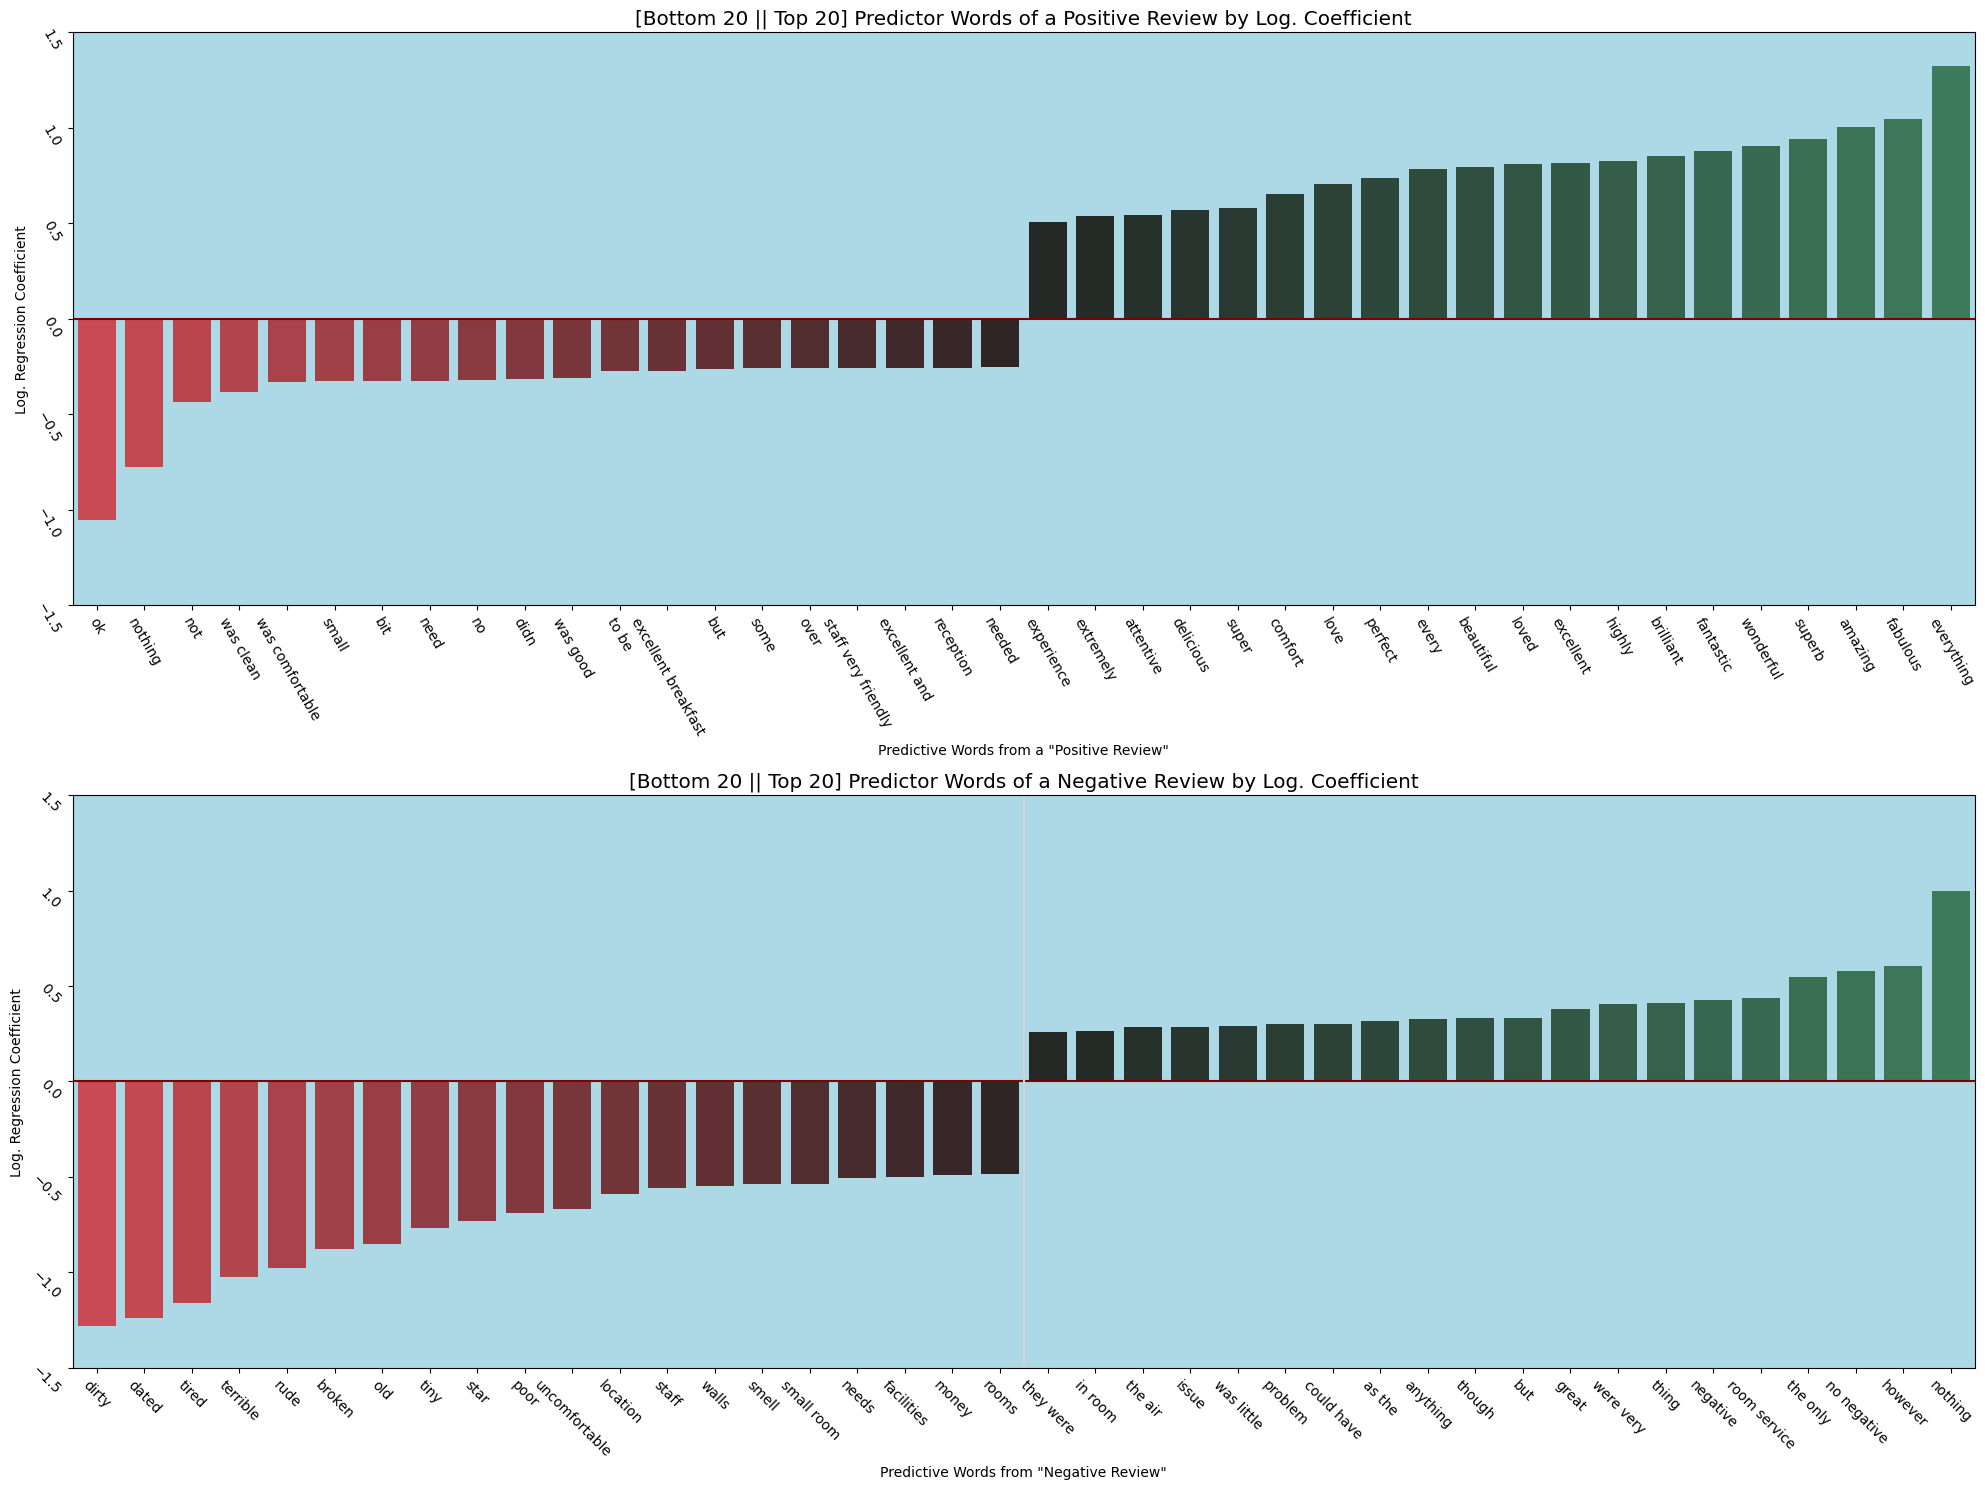

In [218]:
# Top and Bottom 20 graph
# May need to change colors for visually impaired


fig,axes = plt.subplots(2,1,figsize=(20,15),layout='tight')
#plt.subplot(121)
# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(212)
ax=axes[0]
axes[0].set_title('[Bottom 20 || Top 20] Predictor Words of a Positive Review by Log. Coefficient',size='x-large')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax.set_facecolor('lightblue')
sns.barplot(data=Positive_Review_TopBottom20,x='feat',y='coef',palette=palette,ax=axes[0])
axes[0].tick_params(rotation=-60)
plt.axhline(y=0,color='maroon')
plt.axvline(x=(19.5),color='lightgray')
axes[0].set_xlabel('Predictive Words from a "Positive Review"')
axes[0].set_ylabel('Log. Regression Coefficient')
axes[0].set_ylim(-1.5,1.5)
plt.ylabel('Log.Reg. Coefficients')


# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(211)
ax1=axes[1]
axes[1].set_title('[Bottom 20 || Top 20] Predictor Words of a Negative Review by Log. Coefficient',size='x-large')
sns.barplot(data=Negative_Review_TopBottom20,x='feat',y='coef',palette=palette,ax=axes[1])
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax1.set_facecolor('lightblue')
sns.color_palette()
ax.axhline(y=0,color='maroon')
ax1.axvline(x=(19.5),color='lightgray')
axes[1].tick_params(labelrotation=-45)
axes[1].set_xlabel('Predictive Words from "Negative Review"')
axes[1].set_ylabel('Log. Regression Coefficient')
axes[1].set_ylim(-1.5,1.5)
plt.show()



In [ ]:
from scipy import stats

_(Edit: I must have my syntax wrong or something because the words I tried to prevent through stop words or other means in the model are still there.)_
The above plot would be presentable to a client, as would likely be the case in this case study.
The plot below is for illustrative points related to the distribution of the log regression coefficient.
These plots came from the same model and so can be compared to each other.

_**Observations**_:
- Universtal
- The graph above shows the extremes of the coefficient values, which speaks to a weighted interpretation of the terms involved.
- The graph below demonstrates the distribution of the coefficient values around the 0 value. This paints a different picture. Both review are fairly similar in distrubution about the center. The top and bottom 20 might be considered outliers. With a standard deviation of approximate .22 for either category, these values overlap consistently.These outliers are pronnounced outside the normal distribution.

_**Actionable items, as pertaining to a client:**_

- There are two perspectives and approaches for guest retainability based on reviews, mostly with relevance to operating costs. One is an overhaul approach, the worst predictors all speak to complete guests unhappiness. This, however, is costly and complex.

- The second is to select, emphasize the lowest cost highest impact concepts based on these terms."The air" - air conditioner, air quality - whichever is easier to address. Growing the positive coef in the neg group is the low hanging fruit. These probably stem from more minor inconvenience others.
  
- Continue delivering the positive experience and emphasize amenities like the breakfast service or a well trained staff. It might be more impacting to inundate guests with the positive keywords found on this list too: brilliant, fabulous, excellent. Hearing the words will stick in guests minds.

- There are a number of "negative" terms that still increase the chance of a positive review and addressing those should be the first focus of management. It's the easiest
- The terminology for positive review with pos coef are markedly more animated than the positive reviews with negative coef.


In [ ]:
import statistics as stat
fig,axes = plt.subplots(1,2,figsize=(10,6),layout='tight')
#plt.subplot(121)
# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()

plt.subplot(121)
ax=axes[0]
axes[0].set_title('44.4% Negatively Corellated Positive Reviews')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax.set_facecolor('lightblue')
sns.histplot(Xtf_pos.coef,palette=palette,ax=axes[0],stat='density')
#ax = sns.histplot(Xtf_pos, kde=False, stat='density', label='samples')
axes[0].tick_params(rotation=-60)
#plt.axhline(y=0,color='maroon')
plt.axvline(x=0,color='red')
plt.axvline(x=0.22996,color='yellow')
plt.axvline(x=-0.22996,color='yellow')
axes[0].set_xlabel('Logistic Regression Coefficient')
axes[0].set_ylabel('Counts')
axes[0].set_ylim(0,3.75)
plt.ylabel('Log.Reg. Coefficients')


# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(122)
ax1=axes[1]
axes[1].set_title('41.1% Positively Corellated Negative Reviews')
sns.histplot(Xtf_neg.coef,palette=palette,ax=axes[1],stat='density')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax1.set_facecolor('lightblue')
sns.color_palette()
#ax.axhline(y=0,color='maroon')
ax1.axvline(x=0,color='red')
plt.axvline(x=0.22596,color='yellow')
plt.axvline(x=-0.22596,color='yellow')
axes[1].tick_params(labelrotation=-45)
axes[1].set_xlabel('Logistic Regression Coefficient')
axes[1].set_ylabel('Counts')
axes[1].set_ylim(0,3.75)

plt.suptitle('Distribution about in Positive (L) and Negative (R) Coefficient Distribution')
plt.show()
Xtc_Co['pos'].mean()

There is more insight to be gained from these visualizations that are presentable to a client, but that can be touched on later.

In [219]:
# Standrd  deDev for both categories.
print(stats.tstd(Xtf_pos.coef))
stats.tstd(Xtf_neg.coef)

0.22835056947569607


0.22183288120427933

In [ ]:
#Separating review types again to evaluate distribution
Xtf_pos=Xtf_Co[Xtf_Co.review_type=='pos']
Xtf_neg=Xtf_Co[Xtf_Co.review_type=='neg']

In [212]:
pos_rev_neg_coef=(Xtf_pos[Xtf_pos.coef<0].coef.count()/500)
neg_rev_pos_coef=(Xtf_neg[Xtf_neg.coef>0].coef.count()/500)
print('"Positive" Review commentary with negative Coefficients: ',pos_rev_neg_coef*100,'%')
print('"Negative" Review commentary with negative Coefficients: ',neg_rev_pos_coef*100,'%')

"Positive" Review commentary with negative Coefficients:  44.4 %
"Negative" Review commentary with negative Coefficients:  41.4 %


In [220]:
tprint('C+ Great Success!')

  ____           ____                     _     ____                                      _ 
 / ___|   _     / ___| _ __   ___   __ _ | |_  / ___|  _   _   ___   ___   ___  ___  ___ | |
| |     _| |_  | |  _ | '__| / _ \ / _` || __| \___ \ | | | | / __| / __| / _ \/ __|/ __|| |
| |___ |_   _| | |_| || |   |  __/| (_| || |_   ___) || |_| || (__ | (__ |  __/\__ \\__ \|_|
 \____|  |_|    \____||_|    \___| \__,_| \__| |____/  \__,_| \___| \___| \___||___/|___/(_)
                                                                                            



_**But...what am I predicting here? This would be the top most impacting words in the negative or positive review features, correct?**_<br>
Let's check

Train and test scores are pretty close! Both are capable of producing the right results about 78.8% of the time.<br>
This is in a unified model. With invidiual

In [221]:
# Sanity check?
df_name
name_i=0
df_name[0]
df_name

NameError: name 'df_name' is not defined

#### Word Count / Interpretations

## Question 4 <a class="anchor" name="Part4"></a>

Using a pipeline, combine PCA with a decision tree classifier.

Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.
You can use 20 principle components.
The best parameters should be found using 5-fold cross validation.

In [ ]:
hotel_pipe=pd.read_csv('data/Hotel_Reviews.csv')

Using a standard ML Pipeline Template, as provided in lecture:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#a bunch of imports!
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

#Load Data
hotel_pipe=hotel.copy()
hotel_pipe.drop(columns=['Positive_Review','Negative_Review'],inplace=True)
hotel_pipe.isna().sum().sum()

In [ ]:
hotel_pipe

In [ ]:

#########
###### EDA #######
#########

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(
    hotel[['Positive_Review','Negative_Review']],
    hotel['Reviewer_Score'], 
    test_size=0.2, random_state=42)
#######
##### ETL #########
#######

#scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

########
##### FEATURE DECOMPOSITION ##########
########

#decompose
pca = PCA(n_components=20)
pca.fit(X_train)
X_train = pca.transform(X_train)

#fit
#knn = KNeighborsClassifier(n_neighbors=13)
#model = knn.fit(X_train, y_train)

print(f"The Train score is: {model.score(X_train, y_train)}")

In [ ]:
x_train.shape

In [ ]:
# Confirming the test/train set
print(X_train.shape)
X_test.shape

In [ ]:
my_PCA=PCA()
my_PCA.fit(X_train)

In [ ]:
X_train_PCA=my_PCA.transform(X_train)
X_test_PCA=my_PCA.transform(X_test)

In [ ]:
print(X_train.shape)
print(X_train_PCA.shape)

In [ ]:
print(f"Variance captured by PC1: {my_PCA.explained_variance_[0]: 0.3f}")
print(f"Variance captured by PC2: {my_PCA.explained_variance_[1]: 0.3f}")

print(f"Proportion of variance captured by PC1: {my_PCA.explained_variance_ratio_[0]: 0.3f}")
print(f"Proportion of variance captured by PC2: {my_PCA.explained_variance_ratio_[1]: 0.3f}")

Only ~21% of variation in PC1.
Only 12.4% of variation in PC2. 
Now going to look at Explained Var Ratio

In [ ]:
expl_var = my_PCA.explained_variance_ratio_


In [ ]:
expl_var[:100]

In [ ]:
plt.figure()
plt.plot(range(1,21),expl_var[:20],marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,21,1))
plt.show()

Scree shows that after 3 PC variance additional Variance Explained becomes pretty minimal

In [ ]:
cum_sum=np.cumsum(expl_var)

In [ ]:
cum_sum

In [ ]:
# Plot out the cumulative sum graph

plt.figure()
plt.plot(range(1,100), cum_sum[:99], marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,21,2))
plt.show()

## Scrap

In [ ]:
hotel[hotel.columns[24:28]].sum()/hotel[hotel.columns[24:29]].sum().sum()

In [ ]:
hotel['Hotel_Address_Other']=pd.merge([hotel['Hotel_Address_Vienna'],hotel['Hotel_Address_Milan']])
hotel_df=hotel.drop(columns=['Hotel_Address_Milan','Hotel_Address_Vienna'])
hotel_df

In [ ]:
X_train_tb20=pd.concat([X_train[Xtf_Co.feat2.head(20)],X_train[Xtf_Co.feat2.tail(20)]],axis=1).fillna('0').astype(dtype=int)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample text data
X_train

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(X_train)

# Print the resulting TF-IDF matrix
print(X.toarray())

In [ ]:
import 

In [ ]:
test_neg=pd.DataFrame()

In [ ]:
test_neg['coef']=neg_coef
test_neg['names']=neg_coef_names

In [ ]:
test_neg.sort_values(by='coef',ascending=False)

In [ ]:
neg_words.sort_values(ascending=False)

In [ ]:
print('df:',sys.getsizeof(test_neg))
print('s:',sys.getsizeof(neg_words))

In [ ]:
X_final_reversed.info()

In [ ]:
X_final_reversed.index

In [ ]:
test_neg.iloc[1]

In [ ]:
X_train_

In [ ]:
x_final_coef['coef']=log_reg.coef_

In [ ]:
X_train_reversed

In [ ]:
sys.getsizeof(X_train)

In [ ]:
print(X_train.info())
X_train.index

In [ ]:
print(X_final_reversed.info())
X_final_reversed.index

len(hotel_neg[hotel_neg.Positive_Review=='No Positive'])

In [ ]:
hotel.groupby(['Additional_Number_of_Scoring','Total_Number_of_Reviews','Average_Score']).Nights_Stayed.mean()

In [ ]:
hotel['Positive_Review',

In [ ]:
len(hotel_neg[hotel_neg.Negative_Review=='No Negative'])

In [ ]:
len(hotel_pos[hotel_pos.Positive_Review=='No Positive'])

In [ ]:
hotel_neg[hotel_neg.Negative_Review=='No Negative']